In [2]:
# !pip uninstall zonepy -y
# !pip install git+https://github.com/HOUPU1993/zonepy.git

In [3]:
# pip install pandas==2.1.4 geopandas==0.14.2

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import glob

from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import mapping

from joblib import Parallel, delayed
from tqdm import tqdm

# input my libraries
from zonepy import zp_get_crs
from zonepy import zp_find_district_idx
from zonepy import zp_read_dist
from zonepy import zp_read_pcl
from zonepy import zp_read_bldg
from zonepy import zp_get_dist_def
from zonepy import zp_get_parcel_dim
from zonepy import zp_get_parcel_geo
from zonepy import zp_get_unit_info
from zonepy import zp_get_variables
from zonepy import zp_get_zoning_req
from zonepy import zp_check_unit
from zonepy import zp_check_res_type
from zonepy import zp_check_constraints
from zonepy import zp_add_setbacks
from zonepy import zp_get_buildable_area
from zonepy import zp_check_fit
from zonepy import possible_checks


from zonepy import find_bldg_type
from zonepy import check_land_use
from zonepy import get_zoning_req
from zonepy import check_fl_area
from zonepy import check_far
from zonepy import check_height
from zonepy import check_stories
from zonepy import check_bedrooms
from zonepy import check_lot_coverage
from zonepy import check_unit_density
from zonepy import check_unit_qty
from zonepy import add_setbacks
from zonepy import get_buildable_area
from zonepy import filter_constraints
from zonepy import check_zoning_process
from zonepy import parcels_in_zoning
from zonepy import parcel_in_confidence
from zonepy import parcel_in_nonconfidence
from zonepy import generate_parcel_info
from zonepy import check_height_eave

from zonepy.check_footprint import check_footprint
from zonepy.check_unit_size import check_unit_size
from zonepy.process_all_districts import process_all_districts

from zonepy import compare_id_differences
# from zonepy import zoning_analysis_pipeline

# Re-construct the Data

In [5]:
# tidyparcel_feeds = tidyparcel_geo_feeds.merge(tidyparcel_dim_feeds[['parcel_id','lot_width','lot_depth','lot_area','confidence']], on='parcel_id', how='left')

# mask = tidyparcel_feeds['side'] != 'centroid'
# tidyparcel_feeds.loc[mask, ['lot_width','lot_depth','lot_area','confidence']] = np.nan

# unqiue_id = tidyparcel_feeds[tidyparcel_feeds['confidence'] == 'non_confidence_parcel']['parcel_id'].unique()
# tidyparcel_feeds.loc[(tidyparcel_feeds['parcel_id'].isin(unqiue_id)) & (tidyparcel_feeds['side'] != 'centroid'), 'side'] = 'Unknown'

# tidyparcel_feeds[['Prop_ID','parcel_id','parcel_label','side','lot_width','lot_depth','lot_area','geometry']].to_crs("EPSG:4326").to_file(r"/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds.geojson", driver='GeoJSON')
# tidyparcel_feeds[tidyparcel_feeds['side'] == 'centroid'][['parcel_id','landuse','landuse_spec','confidence']].to_csv(r"/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds_land_use.csv", index=False)

In [6]:
# tidyparcel_feeds = gpd.read_file(r"/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds.geojson")
# tidyparcel_feeds

In [7]:
# # Example usage:
# process_all_districts(
#     tidyparcel_path="/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds.geojson",
#     district_folder="/Users/houpuli/Dropbox/ceshi/ozfs_without_overlay/",
#     output_folder="/Users/houpuli/Dropbox/ceshi/tidyparcel_feeds/"
# )

# Step 1: some necessary functions
For the functions of this part, you don't have to run them, because all of them were intergrated into the later functions, I list them here just for your reference.

## `zp_get_crs` function
Kamryn uploaded a state plane reference to [guihub](https://raw.githubusercontent.com/KamrynMansfield/tidyzoning/main/inst/extdata/sp_crs.geojson), and this function will refer you to get the correct crs of the geojson file. And this function is used in the `zp_read_pcl` function.

In [8]:
Addison_district = gpd.read_file(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
print('The matched crs is EPSG:', zp_get_crs(Addison_district.loc[[0]]))

The matched crs is EPSG: 32138


## `zp_find_district_idx` function

This function finds the indices of districts in `tidyzoning` (e.g., `Addison_district`) that contain the centroids of parcels in `tidyparcel` (e.g., `Addison_parcels`). It returns a DataFrame with columns for "parcel_id" (from `tidyparcel`) and "zoning_id" (the index of the matching district in `tidyzoning`). This output is used in the `zp_read_dist` function.

In [9]:
Addison_district = gpd.read_file(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
Addison_parcels = gpd.read_file(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyparcel_feeds/Addison.parcel")
zp_find_district_idx(Addison_parcels,Addison_district)

,parcel_id,zoning_id
5,Dallas_County_combined_parcel_101985,11
10,Dallas_County_combined_parcel_102535,5
10,Dallas_County_combined_parcel_102535,11
18,Dallas_County_combined_parcel_103676,11
32,Dallas_County_combined_parcel_103690,11
...,...,...
16430,Dallas_County_combined_parcel_81817,14
16437,Dallas_County_combined_parcel_81818,14
16442,Dallas_County_combined_parcel_81819,27
16447,Dallas_County_combined_parcel_81822,5


# Step 2: Read files

## 01.`zp_read_dist` function
this function is for reading district info, and it will deleted those districts without valid geometry and re-index the structure, besides it will also auto-reproject the district data to the target crs by using "zp_get_crs" fucntion, while this function also allow you to input the target crs by yourself.

In [10]:
Addison_district = zp_read_dist(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning", trans_crs=3857)
print("current crs is", Addison_district.crs)
Addison_district.head(5)

current crs is EPSG:3857


,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry,zoning_id
0,Single-Family Dwelling,R-1,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.2...,"MULTIPOLYGON (((-10780184.101 3887684.743, -10...",0.0
1,Single-Family Dwelling,R-16,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.3...,"MULTIPOLYGON (((-10777090.621 3888246.808, -10...",1.0
2,Apartment Dwelling,A,False,False,"[2_unit, 3_unit, 4_plus, townhome]",{'lot_size': {'min_val': [{'expression': ['1']...,"MULTIPOLYGON (((-10778516.328 3891864.967, -10...",2.0
3,Local Retail,LR,False,False,NaN,NaN,"MULTIPOLYGON (((-10781846.642 3887084.891, -10...",3.0
4,Commercial-1,C-1,False,False,NaN,NaN,"MULTIPOLYGON (((-10778798.181 3888383.694, -10...",4.0


In [11]:
Addison_district = zp_read_dist(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning", trans_crs=None)
print("current crs is", Addison_district.crs)
Addison_district.head(5)

current crs is EPSG:32138


,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry,zoning_id
0,Single-Family Dwelling,R-1,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.2...,"MULTIPOLYGON (((755203.329 2142711.882, 755202...",0.0
1,Single-Family Dwelling,R-16,False,False,[1_unit],{'lot_size': {'min_val': [{'expression': ['0.3...,"MULTIPOLYGON (((757793.793 2143223.087, 757790...",1.0
2,Apartment Dwelling,A,False,False,"[2_unit, 3_unit, 4_plus, townhome]",{'lot_size': {'min_val': [{'expression': ['1']...,"MULTIPOLYGON (((756548.273 2146227.618, 756547...",2.0
3,Local Retail,LR,False,False,NaN,NaN,"MULTIPOLYGON (((753814.918 2142188.501, 753814...",3.0
4,Commercial-1,C-1,False,False,NaN,NaN,"MULTIPOLYGON (((756357.973 2143314.560, 756354...",4.0


## 02.`zp_read_pcl` function
this funcion is for reading parcel info, and it will auto-match the same crs with the "district dataframe" created above(you cannot define the crs by yourself, because we must keep the same crs between "dist data" and "parcel_data", if you want to change the crs, you have define a crs by above "zp_read_dist" fucntion, and run "zp_read_pcl" fucntion again, and you will find the crs will change). Besides, this function will also add a "zoning_id" column to each parcel centroid row, which is the index of the district that contains the parcel centroid.

In [12]:
Addison_parcels = zp_read_pcl(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyparcel_feeds/Addison.parcel", Addison_district)
print("current crs is", Addison_parcels.crs)
Addison_parcels.head(5)

current crs is EPSG:32138


,parcel_id,side,lot_width,lot_depth,lot_area,geometry,zoning_id
0,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (753828.148 2141685.199, 753833.116...",NaN
1,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (753829.043 2141675.507, 753828.148...",NaN
2,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (754035.787 2141676.898, 754034.848...",NaN
3,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (754033.430 2141771.045, 754035.787...",NaN
4,Dallas_County_combined_parcel_101985,unknown,NaN,NaN,NaN,"LINESTRING (754000.588 2141799.274, 754033.430...",NaN


#### `zp_get_parcel_dim` function
this funcion is for extracting all parcel dimension data("lot_width","lot_depth","lot_area") from original parcel data and correponding "parcel_id", besides, it will also split the parcel into two parts("corner" or "regular") by identidying whether "exterior side" exists or not.

In [13]:
zp_get_parcel_dim(Addison_parcels)

,parcel_id,lot_width,lot_depth,lot_area,lot_type,conf,zoning_id
0,Dallas_County_combined_parcel_101985,1.000000,1.000000,3.029635,regular,no,9.0
1,Dallas_County_combined_parcel_102535,119.814881,208.678146,0.573980,regular,yes,3.0
2,Dallas_County_combined_parcel_102535,119.814881,208.678146,0.573980,regular,yes,9.0
3,Dallas_County_combined_parcel_103676,1.000000,1.000000,9.071160,regular,no,9.0
4,Dallas_County_combined_parcel_103690,1.000000,1.000000,4.768296,regular,no,9.0
...,...,...,...,...,...,...,...
2635,Dallas_County_combined_parcel_81817,1.000000,1.000000,0.094835,regular,no,12.0
2636,Dallas_County_combined_parcel_81818,1.000000,1.000000,0.102011,regular,no,12.0
2637,Dallas_County_combined_parcel_81819,124.065756,401.645015,1.136832,regular,yes,15.0
2638,Dallas_County_combined_parcel_81822,194.852130,391.729181,1.733046,corner,yes,3.0


#### `zp_get_parcel_geo` function
this funcion is for extracting all confident parcel geometry without "centroid" points, which is useful for later "zp_get_buildable_area" function and "zp_check_fit"

In [14]:
zp_get_parcel_geo(Addison_parcels)

,parcel_id,side,geometry
0,Dallas_County_combined_parcel_102535,interior side,"LINESTRING (753814.050 2142187.387, 753750.347..."
1,Dallas_County_combined_parcel_102535,rear,"LINESTRING (753813.755 2142223.962, 753814.050..."
2,Dallas_County_combined_parcel_102535,interior side,"LINESTRING (753750.053 2142223.668, 753813.755..."
3,Dallas_County_combined_parcel_102535,front,"LINESTRING (753750.347 2142187.093, 753750.053..."
4,Dallas_County_combined_parcel_104000,interior side,"LINESTRING (753824.836 2142394.500, 753824.880..."
...,...,...,...
6500,Dallas_County_combined_parcel_81822,exterior side,"LINESTRING (754066.019 2142655.691, 754066.948..."
6501,Dallas_County_combined_parcel_81827,exterior side,"LINESTRING (753795.082 2142412.365, 753749.363..."
6502,Dallas_County_combined_parcel_81827,front,"LINESTRING (753749.363 2142412.121, 753749.279..."
6503,Dallas_County_combined_parcel_81827,interior side,"LINESTRING (753749.279 2142457.881, 753794.999..."


## 03.`zp_read_bldg` function
this function is for reading preliminary building info, transferring json file into dictionary format, which is useful for "get_variables_function" later.

In [15]:
zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")

{'bldg_info': {'height_top': 38,
  'height_plate': 37,
  'roof_type': 'flat',
  'width': 52,
  'depth': 48,
  'parking': 4,
  'sep_platting': False},
 'unit_info': [{'fl_area': 1108,
   'bedrooms': 3,
   'qty': 4,
   'entry_level': 1,
   'outside_entry': True}],
 'level_info': [{'level': 1, 'gross_fl_area': 1534},
  {'level': 2, 'gross_fl_area': 1533},
  {'level': 3, 'gross_fl_area': 1533}]}

## 04.`zp_get_dist_def` function
this funcion is for extracting definition from the "district data" by input dist path, including "height" and "res_type".

In [16]:
zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")

{'height': [{'condition': "roof_type == 'flat'", 'expression': 'height_top'},
  {'condition': "roof_type == 'hip'",
   'expression': '0.5 * (height_top + height_eave)'},
  {'condition': "roof_type == 'mansard'", 'expression': 'height_deck'},
  {'condition': "roof_type == 'gable'",
   'expression': '0.5 * (height_top + height_eave)'},
  {'condition': "roof_type == 'skillion'",
   'expression': '0.5 * (height_top + height_eave)'},
  {'condition': "roof_type == 'gambrel'",
   'expression': '0.5 * (height_top + height_eave)'}],
 'res_type': [{'condition': 'total_units == 1', 'expression': "'1_unit'"},
  {'condition': 'total_units == 2', 'expression': "'2_unit'"},
  {'condition': ['total_units > 2',
    'n_outside_entry == total_units',
    'n_ground_entry == total_units',
    'sep_platting == TRUE'],
   'expression': "'townhome'"},
  {'condition': 'total_units == 3', 'expression': "'3_unit'"},
  {'condition': 'total_units > 3', 'expression': "'4_plus'"}]}

# Functions

## `zp_get_variables` function
this function is for extracting and calculating building info by query data from dist info, and it will return a dataframe with all the variables you need, involving the "height" and "res_type" at the end of dataframe. The "bldg_data" and "zoning_data" can be input as dict or path, the "parcels_data" and "district_data" only can be geodataframe generated by`zp_read_pcl` and `zp_read_dist` functions.   
And this function will be intergrated into the `zp_get_zoning_req` function later.

In [17]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id'] == 'Dallas_County_combined_parcel_51626']
district_data = Addison_district.loc[[13]]
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [18]:
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)
vars

,bldg_depth,bldg_width,dist_abbr,fl_area,fl_area_first,fl_area_top,floors,height_deck,height_eave,height_plate,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,lot_cov_bldg,unit_density,far,height,res_type
0,48,52,UC,4600,1534,1533,3,38,38,37,...,0.0,0.0,1.0,0.0,1108.0,206.838276,144.389027,3.811923,38,4_plus


In [19]:
vars = zp_get_variables(r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg',parcel_data, district_data, r'/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning')
vars

,bldg_depth,bldg_width,dist_abbr,fl_area,fl_area_first,fl_area_top,floors,height_deck,height_eave,height_plate,...,unit_pct_1bed,unit_pct_2bed,unit_pct_3bed,unit_pct_4bed,unit_size_avg,lot_cov_bldg,unit_density,far,height,res_type
0,48,52,UC,4600,1534,1533,3,38,38,37,...,0.0,0.0,1.0,0.0,1108.0,206.838276,144.389027,3.811923,38,4_plus


## `zp_get_zoning_req` function
this function is for calculating specific zoning requirements based on the provided extracting variables and district data. It returns a DataFrame containing the constraints for each district, including variables such as "setback", "lot_coverage", and "height"(not including "unit_size", we have another function `check_unit`for that).

In [20]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id'] == 'Dallas_County_combined_parcel_51626']
district_data = Addison_district.loc[[13]]
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [21]:
district_data.iloc[0]['constraints']

{'setback_front': {'min_val': [{'condition': 'Along any public streets except long residential streets (category C) and residential mew streets (category D)',
    'expression': '10'},
   {'condition': ['Along a residential street (category C)',
     'Building fronts public open space or 25 percent of blockface has an 8 ft setback'],
    'expression': '5'},
   {'condition': ['Along a residential street (category C)',
     '75 percent of blockface has an 5 foot setback'],
    'expression': '8'},
   {'condition': 'Along a residential mew street (category D)',
    'expression': '0'}]},
 'setback_side_ext': {'min_val': [{'condition': 'Along any public streets except long residential streets (category C) and residential mew streets (category D)',
    'expression': '10'},
   {'condition': ['Along a residential street (category C)',
     'Building fronts public open space or 25 percent of blockface has an 8 ft setback'],
    'expression': '5'},
   {'condition': ['Along a residential street (ca

In [22]:
zoning_req = zp_get_zoning_req(district_data, bldg_data, parcel_data, dist_def)
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,setback_front,"(0.0, 10.0)",NaN,None,None
1,setback_side_ext,"(0.0, 10.0)",NaN,None,None
2,setback_dist_boundary,10.0,NaN,None,None
3,lot_cov_bldg,None,85.00,None,None
4,parking_uncovered,8.0,NaN,None,None
5,height,40.0,92.00,None,None
6,far,None,1.78,None,None


In [23]:
zoning_req = zp_get_zoning_req(district_data, bldg_data=None, parcel_data=None, zoning_data=None, vars=vars)
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,setback_front,"(0.0, 10.0)",NaN,None,None
1,setback_side_ext,"(0.0, 10.0)",NaN,None,None
2,setback_dist_boundary,10.0,NaN,None,None
3,lot_cov_bldg,None,85.00,None,None
4,parking_uncovered,8.0,NaN,None,None
5,height,40.0,92.00,None,None
6,far,None,1.78,None,None


## `zp_check_unit` function
this function is for extracting bedrooms and corresponding fl_area in each unit. And it will check whether the unit is fit for the zoning requirements, and return a DataFrame with the results.

In [24]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id'] == 'Dallas_County_combined_parcel_51626']
district_data = Addison_district.loc[[13]]
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [25]:
Addison_district.loc[13]['constraints']

{'setback_front': {'min_val': [{'condition': 'Along any public streets except long residential streets (category C) and residential mew streets (category D)',
    'expression': '10'},
   {'condition': ['Along a residential street (category C)',
     'Building fronts public open space or 25 percent of blockface has an 8 ft setback'],
    'expression': '5'},
   {'condition': ['Along a residential street (category C)',
     '75 percent of blockface has an 5 foot setback'],
    'expression': '8'},
   {'condition': 'Along a residential mew street (category D)',
    'expression': '0'}]},
 'setback_side_ext': {'min_val': [{'condition': 'Along any public streets except long residential streets (category C) and residential mew streets (category D)',
    'expression': '10'},
   {'condition': ['Along a residential street (category C)',
     'Building fronts public open space or 25 percent of blockface has an 8 ft setback'],
    'expression': '5'},
   {'condition': ['Along a residential street (ca

In [26]:
zp_check_unit(district_data, bldg_data, vars)

True

## `zp_check_res_type` function
this function is for checking whether the building is allowed by district use_type?

In [27]:
zp_check_res_type(vars, district_data)

True

## `zp_check_constraints` function
this function is for checking whether the variables is allowed by zoning requirements.

In [28]:
zp_check_constraints(vars, zoning_req, checks=['lot_cov_bldg'])

,constraint_name,allowed
3,lot_cov_bldg,False


In [29]:
zp_check_constraints(vars, zoning_req, checks=None)

,constraint_name,allowed
3,lot_cov_bldg,False
5,height,False
6,far,False


## `zp_add_setbacks` function
assign setback info of each zoning req to the parcel geo data, which is useful for later "zp_get_buildable_area" function.

In [30]:
bldg_data = zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidybuilding/4_fam_wide.bldg")
parcel_dim = zp_get_parcel_dim(Addison_parcels)
parcel_data = parcel_dim[parcel_dim['parcel_id'] == 'Dallas_County_combined_parcel_51626']
district_data = Addison_district.loc[[13]]
dist_def = zp_get_dist_def(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")
vars = zp_get_variables(bldg_data, parcel_data, district_data, dist_def)

In [31]:
zoning_req = zp_get_zoning_req(district_data, bldg_data=None, parcel_data=None, zoning_data=None, vars=vars)
parcel_geo = zp_get_parcel_geo(Addison_parcels)
parcel_geo_data = parcel_geo[parcel_geo['parcel_id'] == 'Dallas_County_combined_parcel_51626']

In [32]:
parcel_geo_data

,parcel_id,side,geometry
1158,Dallas_County_combined_parcel_51626,front,"LINESTRING (756507.050 2145230.105, 756507.038..."
1159,Dallas_County_combined_parcel_51626,interior side,"LINESTRING (756507.038 2145236.810, 756523.810..."
1160,Dallas_County_combined_parcel_51626,interior side,"LINESTRING (756523.819 2145230.127, 756507.050..."
1161,Dallas_County_combined_parcel_51626,rear,"LINESTRING (756523.810 2145236.833, 756523.819..."


In [33]:
zoning_req

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,setback_front,"(0.0, 10.0)",NaN,None,None
1,setback_side_ext,"(0.0, 10.0)",NaN,None,None
2,setback_dist_boundary,10.0,NaN,None,None
3,lot_cov_bldg,None,85.00,None,None
4,parking_uncovered,8.0,NaN,None,None
5,height,40.0,92.00,None,None
6,far,None,1.78,None,None


In [34]:
# zoning_req.at[2, 'min_value'] = (10.0, 15.0)

In [35]:
parcels_with_setbacks = zp_add_setbacks(parcel_geo_data, district_data, zoning_req)
parcels_with_setbacks

,parcel_id,side,geometry,setback,on_boundary
1158,Dallas_County_combined_parcel_51626,front,"LINESTRING (756507.050 2145230.105, 756507.038...",10.0,True
1159,Dallas_County_combined_parcel_51626,interior side,"LINESTRING (756507.038 2145236.810, 756523.810...",None,False
1160,Dallas_County_combined_parcel_51626,interior side,"LINESTRING (756523.819 2145230.127, 756507.050...",None,False
1161,Dallas_County_combined_parcel_51626,rear,"LINESTRING (756523.810 2145236.833, 756523.819...",None,False


## `zp_get_buildable_area` function
assign setback info of each zoning req to the parcel geo data, which is useful for later "zp_get_buildable_area" function.

In [36]:
buildable_area = zp_get_buildable_area(parcels_with_setbacks)
buildable_area

,parcel_id,buildable_geometry_relaxable,buildable_geometry_strict
0,Dallas_County_combined_parcel_51626,"POLYGON ((756510.0865166849 2145236.783766531,...","POLYGON ((756510.087 2145236.784, 756523.779 2..."


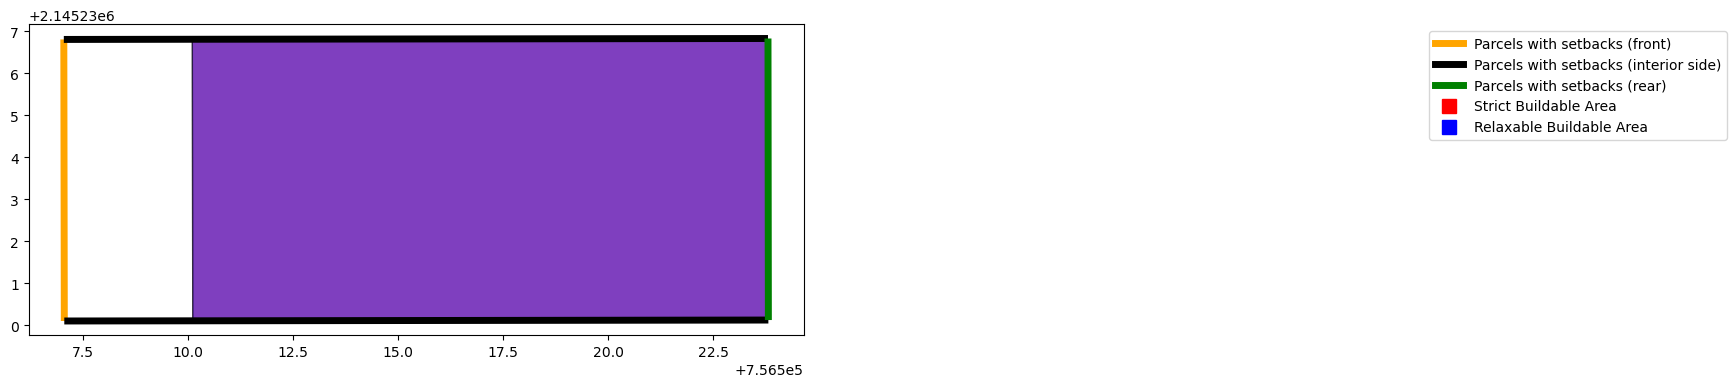

In [37]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Define a mapping from 'side' values to colors.
color_mapping = {
    'Interior side': 'red',
    'Exterior side': 'blue',
    'rear': 'green',
    'front': 'orange'
}

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the setbacks results by grouping based on the 'side' column.
for side, group in parcels_with_setbacks.groupby('side'):
    group.plot(
        ax=ax, 
        color=None, 
        alpha=1, 
        edgecolor=color_mapping.get(side, 'black'), 
        linewidth=5, 
        label=f'Parcels with setbacks ({side})'
    )

# Plot the strict buildable area.
strict_area = buildable_area.copy().set_geometry('buildable_geometry_strict')
strict_area.plot(
    ax=ax, 
    color='red', 
    alpha=0.5, 
    edgecolor='black', 
    label='Strict Buildable Area'
)

# Plot the relaxable buildable area.
relaxable_area = buildable_area.copy().set_geometry('buildable_geometry_relaxable')
relaxable_area.plot(
    ax=ax, 
    color='blue', 
    alpha=0.5, 
    edgecolor='black', 
    label='Relaxable Buildable Area'
)

# Create custom legend handles.
handles = []
# Add legend handles for each setbacks side.
for side in parcels_with_setbacks['side'].unique():
    color = color_mapping.get(side, 'black')
    handle = mlines.Line2D([], [], color=color, linewidth=5, label=f'Parcels with setbacks ({side})')
    handles.append(handle)
# Add handles for the buildable area layers.
handles.append(mlines.Line2D([], [], color='red', marker='s', markersize=10,
                             markerfacecolor='red', linestyle='None',
                             label='Strict Buildable Area'))
handles.append(mlines.Line2D([], [], color='blue', marker='s', markersize=10,
                             markerfacecolor='blue', linestyle='None',
                             label='Relaxable Buildable Area'))

ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(2.2, 1))
plt.show()

## `zp_check_fit` function
check whether the building footprint can fit into the parcel buildable_area.

In [38]:
zp_check_fit(buildable_area, vars)

,parcel_id,allowed
0,Dallas_County_combined_parcel_51626,False


## `zp_run_zoning_checks` function
check whether the building footprint can fit into the parcel buildable_area.

In [43]:
district_data

,dist_name,dist_abbr,planned_dev,overlay,res_types_allowed,constraints,geometry,zoning_id
13,Urban Center,UC,False,False,"[2_unit, 3_unit, 4_plus, townhome]",{'setback_front': {'min_val': [{'condition': '...,"MULTIPOLYGON (((756660.249 2144843.904, 756601...",13.0


In [47]:
zp_read_bldg(r"/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/ceshi/tidyzonings/Addison.zoning")

{'type': 'FeatureCollection',
 'version': '0.5.0',
 'muni_name': 'Addison',
 'date': '2024-08-14',
 'definitions': {'height': [{'condition': "roof_type == 'flat'",
    'expression': 'height_top'},
   {'condition': "roof_type == 'hip'",
    'expression': '0.5 * (height_top + height_eave)'},
   {'condition': "roof_type == 'mansard'", 'expression': 'height_deck'},
   {'condition': "roof_type == 'gable'",
    'expression': '0.5 * (height_top + height_eave)'},
   {'condition': "roof_type == 'skillion'",
    'expression': '0.5 * (height_top + height_eave)'},
   {'condition': "roof_type == 'gambrel'",
    'expression': '0.5 * (height_top + height_eave)'}],
  'res_type': [{'condition': 'total_units == 1', 'expression': "'1_unit'"},
   {'condition': 'total_units == 2', 'expression': "'2_unit'"},
   {'condition': ['total_units > 2',
     'n_outside_entry == total_units',
     'n_ground_entry == total_units',
     'sep_platting == TRUE'],
    'expression': "'townhome'"},
   {'condition': 'total_u

In [ ]:
import time
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import mapping
import os
import json
import glob

# input my libraries
from zonepy import zp_get_crs
from zonepy import zp_find_district_idx
from zonepy import zp_read_dist
from zonepy import zp_read_pcl
from zonepy import zp_read_bldg
from zonepy import zp_get_dist_def
from zonepy import zp_get_parcel_dim
from zonepy import zp_get_parcel_geo
from zonepy import zp_get_unit_info
from zonepy import zp_get_variables
from zonepy import zp_get_zoning_req
from zonepy import zp_check_unit
from zonepy import zp_check_res_type
from zonepy import zp_check_constraints
from zonepy import zp_add_setbacks
from zonepy import zp_get_buildable_area
from zonepy import zp_check_fit
from zonepy import possible_checks


def zp_run_zoning_checks(
    bldg_file: str,
    parcel_files: list[str],
    zoning_files: list[str],
    detailed_check: bool = False,
    print_checkpoints: bool = True,
    checks: list[str] | None = None,
) -> gpd.GeoDataFrame:
    """
    Python 等价版 zr_run_zoning_checks()，返回每个 parcel_id 是否允许建筑及原因。
    """
    start = time.time()
    # 1. 检查 checks 入参
    if checks is None:
        checks = possible_checks.copy()
    bad = [c for c in checks if c not in possible_checks]
    if bad:
        warnings.warn(f"Unknown constraints: {bad}")

    # 2. 初始要跑的约束（不含 res_type、unit_size、bldg_fit、overlay）
    initial_checks = [
        c for c in checks
        if c not in ("res_type", "unit_size", "bldg_fit", "overlay")
    ]

    # —— 数据准备 —— #
    # 3. 读建筑 JSON
    bldg_data = zp_read_bldg(bldg_file)

    # 4. 读 zoning 图层 + JSON
    zoning_gdfs = []
    zoning_jsons = []
    for i, zfile in enumerate(zoning_files):
        gz = zp_read_dist(zfile)
        gz["muni_id"] = i
        zoning_gdfs.append(gz)

        with open(zfile, 'r') as jf:
            zoning_jsons.append(json.load(jf))

    zoning_all = pd.concat(zoning_gdfs, ignore_index=True)
    overlays    = zoning_all[zoning_all["overlay"]   == True]
    pd_districts= zoning_all[zoning_all["planned_dev"]== True]
    base_zones  = zoning_all[
        (zoning_all["overlay"]   == False) &
        (zoning_all["planned_dev"]== False)
    ]

    # 5. 读 Parcels
    parcel_list = [ zp_read_pcl(p, base_zones) for p in parcel_files ]
    parcels_sf = pd.concat(parcel_list, ignore_index=True)

    # 6. 生成带 “side” 标签的 parcel_geo
    parcel_geo  = zp_get_parcel_geo(parcels_sf)
    # 7. 生成带 centroid 和尺寸的 parcel_dims
    parcel_dims = zp_get_parcel_dim(parcels_sf)

    # 8. 给 parcel_dims 打 zoning_id、pd_id、overlay_id
    parcel_dims = parcel_dims.merge(
        zp_find_district_idx(parcel_dims, base_zones),
        left_index=True, right_index=True, how="left"
    )
    pd_idx = zp_find_district_idx(parcel_dims, pd_districts).rename(columns={"zoning_id":"pd_id"})
    ov_idx = zp_find_district_idx(parcel_dims, overlays  ).rename(columns={"zoning_id":"overlay_id"})
    parcel_dims = parcel_dims.merge(pd_idx[["pd_id"]],   left_index=True, right_index=True, how="left")
    parcel_dims = parcel_dims.merge(ov_idx[["overlay_id"]], left_index=True, right_index=True, how="left")

    # 9. 警告不在任何区的 parcels
    missing = parcel_dims["parcel_id"][parcel_dims["zoning_id"].isna()]
    if not missing.empty:
        warnings.warn(f"{len(missing)}/{len(parcel_dims)} parcels not covered by zoning")

    # 初始化 false/maybe 原因列
    parcel_dims["false_reasons"] = None
    parcel_dims["maybe_reasons"] = None

    false_dfs = []

    # —— 初始 PD 检查 —— #
    if not pd_districts.empty:
        pd_parcels = pd_idx["parcel_id"][pd_idx["pd_id"].notna()]
        mask_pd = parcel_dims["parcel_id"].isin(pd_parcels)
        parcel_dims.loc[mask_pd, "false_reasons"] = (
            parcel_dims.loc[mask_pd, "false_reasons"]
            .fillna("") .apply(lambda s: "PD_dist" if s=="" else s+",PD_dist")
        )
        parcel_dims["check_pd"] = ~mask_pd
        if not detailed_check:
            df0 = parcel_dims[ mask_pd ]
            false_dfs.append(df0)
            parcel_dims = parcel_dims[~mask_pd]

    # —— 逐 parcel 执行 get_variables / get_zoning_req —— #
    vars_map = {}
    req_map  = {}
    for idx, row in parcel_dims.iterrows():
        pid = row["parcel_id"]
        dist_row = zoning_all.loc[zoning_all["zoning_id"] == row["zoning_id"]].iloc[0]
        munijson = zoning_jsons[int(dist_row["muni_id"])]
        v = zp_get_variables(bldg_data, row, dist_row, munijson)
        z = zp_get_zoning_req(dist_row, vars=v)
        vars_map[pid] = v
        req_map[pid]  = z

    # —— 初始约束检查 —— #
    init_results = []
    for idx, row in parcel_dims.iterrows():
        pid = row["parcel_id"]
        v   = vars_map[pid]
        z   = req_map [pid]
        dist_row = zoning_all.loc[zoning_all["zoning_id"] == row["zoning_id"]].iloc[0]

        # 1) 用地类型
        if "res_type" in checks:
            rt_ok = zp_check_res_type(v, dist_row)
            df_rt = pd.DataFrame({"res_type":[rt_ok]})
        else:
            df_rt = pd.DataFrame()

        # 2) 其他定量约束
        try:
            df_cons = zp_check_constraints(v, z, checks=initial_checks)
        except:
            df_cons = pd.DataFrame()
        if not df_cons.empty:
            df_c = df_cons.set_index("constraint_name")["allowed"].to_frame().T
        else:
            df_c = pd.DataFrame()

        # 3) 户型尺寸
        if "unit_size" in checks:
            u_ok = zp_check_unit(v, dist_row)
            df_u = pd.DataFrame({"unit_size":[u_ok]})
        else:
            df_u = pd.DataFrame()

        # 合并
        merged = pd.concat([df_rt, df_c, df_u], axis=1).reset_index(drop=True)
        init_results.append(merged)

        # 记录 FALSE/MAYBE 原因
        vals = merged.iloc[0].astype(str)
        fals = vals[vals=="False"].index.tolist()
        mays = vals[vals=="MAYBE"].index.tolist()
        if fals:
            s = parcel_dims.at[idx,"false_reasons"] or ""
            parcel_dims.at[idx,"false_reasons"] = fals[0] if s=="" else s+","+",".join(fals)
        if mays:
            s = parcel_dims.at[idx,"maybe_reasons"] or ""
            parcel_dims.at[idx,"maybe_reasons"] = mays[0] if s=="" else s+","+",".join(mays)

        # 如果有 FALSE，就剔除
        if ("FALSE" in vals.values) and (not detailed_check):
            false_dfs.append(parcel_dims.loc[[idx]])
            parcel_dims.drop(idx, inplace=True)

    # 把所有初检的结果拼回 parcel_dims
    all_init_df = pd.concat(init_results, ignore_index=True)
    parcel_dims = pd.concat([parcel_dims.reset_index(drop=True), all_init_df.reset_index(drop=True)], axis=1)

    # —— 侧面标签检查 —— #
    if "bldg_fit" in checks and not parcel_dims.empty:
        has_side = parcel_dims["parcel_id"].isin(parcel_geo["parcel_id"])
        # 没有 side
        no_side = ~has_side
        parcel_dims.loc[no_side, "maybe_reasons"] = (
            parcel_dims.loc[no_side, "maybe_reasons"]
            .fillna("") .apply(lambda s: "side_lbl" if s=="" else s+",side_lbl")
        )
        if not detailed_check:
            false_dfs.append(parcel_dims.loc[no_side])
            parcel_dims = parcel_dims[has_side]

    # —— 建面 fit 检查 —— #
    if "bldg_fit" in checks and not parcel_dims.empty:
        for idx, row in parcel_dims.iterrows():
            pid = row["parcel_id"]
            dist_row = zoning_all.loc[zoning_all["zoning_id"]==row["zoning_id"]].iloc[0]
            z   = req_map[pid]
            v   = vars_map[pid]
            sides = parcel_geo[parcel_geo["parcel_id"]==pid]
            pg_sb = zp_add_setbacks(sides, dist_row, z)
            bz    = zp_get_buildable_area(pg_sb)
            fitdf = zp_check_fit(bz, v)
            ok = fitdf.loc[0,"allowed"]
            parcel_dims.at[idx,"bldg_fit"] = ok
            if ok=="MAYBE":
                s = parcel_dims.at[idx,"maybe_reasons"] or ""
                parcel_dims.at[idx,"maybe_reasons"] = "bldg_fit" if s=="" else s+",bldg_fit"
            if ok==False:
                s = parcel_dims.at[idx,"false_reasons"] or ""
                parcel_dims.at[idx,"false_reasons"] = "bldg_fit" if s=="" else s+",bldg_fit"
        if not detailed_check:
            false_dfs.append(parcel_dims[parcel_dims["bldg_fit"]==False])
            parcel_dims = parcel_dims[parcel_dims["bldg_fit"]!=False]

    # —— overlay 检查 —— #
    if "overlay" in checks and not overlays.empty:
        o_parcels = overlays["parcel_id"].unique()
        mask = parcel_dims["parcel_id"].isin(o_parcels)
        parcel_dims.loc[mask,"maybe_reasons"] = (
            parcel_dims.loc[mask,"maybe_reasons"]
            .fillna("") .apply(lambda s: "overlay" if s=="" else s+",overlay")
        )

    # —— 最终合并、输出 —— #
    final = pd.concat(false_dfs + [parcel_dims], ignore_index=True)
    # 计算 allowed & reason
    def summarize(r):
        fr = r.get("false_reasons") or ""
        mr = r.get("maybe_reasons") or ""
        if fr: return (False, fr)
        if mr: return ("MAYBE", mr)
        return (True, "Building allowed")

    final[["allowed","reason"]] = pd.DataFrame(
        final.apply(summarize, axis=1).tolist(),
        index=final.index
    )

    # 保留列
    if not detailed_check:
        out = final[["parcel_id","allowed","reason","geometry"]]
    else:
        drop_cols = [
            "false_reasons","maybe_reasons",
            "lot_width","lot_depth","lot_area","lot_type",
            "zoning_id","pd_id","overlay_id"
        ]
        out = final.drop(columns=[c for c in drop_cols if c in final.columns])

    # 打印汇总
    if print_checkpoints:
        elapsed = time.time() - start
        print(f"zoning checks finished in {elapsed:.1f}s")
        cnt = (out["allowed"]==True).sum()
        may = (out["allowed"]=="MAYBE").sum()
        total= len(out)
        print(f"{cnt}/{total} parcels allow the building; {may}/{total} maybe allow")

    return gpd.GeoDataFrame(out, geometry="geometry", crs=parcel_dims.crs)


## Create Different Functions

### `find_bldg_type` function

In [10]:
find_bldg_type_results = find_bldg_type(tidybuilding_4_fam_wide)
find_bldg_type_results

'4_plus'

### `get_zoning_req` function  
- `find_bldg_type` functiona is integrated internally.

In [6]:
zoning_id = find_district_idx(Dallas_parcels, Dallas_district)
zoning_id[zoning_id['zoning_id'] == 12]

,parcel_id,zoning_id
13260,Collin_County_combined_parcel_157917,12
17484,Collin_County_combined_parcel_176197,12
29920,Collin_County_combined_parcel_227817,12
32766,Collin_County_combined_parcel_239997,12
37033,Collin_County_combined_parcel_259100,12
...,...,...
1560787,Dallas_County_combined_parcel_673595,12
1571277,Dallas_County_combined_parcel_676445,12
1588645,Dallas_County_combined_parcel_685906,12
1590583,Dallas_County_combined_parcel_690594,12


In [11]:
get_zoning_req_results = get_zoning_req(district_data, bldg_data=None, parcel_data=None, zoning_data=None, vars=get_variables_results)
get_zoning_req_results

,constraint_name,min_value,max_value,min_val_error,max_val_error
0,setback_front,20.0,NaN,None,None
1,setback_side_int,6.0,NaN,None,None
2,setback_side_ext,20.0,NaN,None,None
3,setback_rear,10.0,NaN,None,None
4,lot_cov_bldg,NaN,55.0,None,None
5,height,NaN,40.0,None,None
6,unit_size,900.0,NaN,None,None
7,unit_density,NaN,5.5,None,None


### `Check` function

#### 01. `check_land_use` function
- `find_bldg_type` function is integrated internally.

In [8]:
check_land_use_results = check_land_use(tidybuilding_4_fam_wide, Dallas_district)
check_land_use_results

,zoning_id,allowed
0,0,False
1,1,False
2,2,False
3,3,False
4,4,False
5,5,False
6,6,False
7,7,False
8,8,False
9,9,False


#### 02. `check_fl_area` function
- `get_zoning_req` function is integrated internally.

In [9]:
check_fl_area(tidybuilding_4_fam_wide, Dallas_district[Dallas_district['zoning_id'] == 12], Dallas_parcels[Dallas_parcels['parcel_id'] == 'Collin_County_combined_parcel_157917'])

,zoning_id,allowed,constraint_min_note,constraint_max_note
0,12,True,None,None


In [10]:
check_fl_area_result_all = check_zoning_process(tidybuilding_4_fam_wide, Dallas_district, Dallas_parcels, check_fl_area, n_jobs=12)
check_fl_area_result_all

Parallel Processing:   2%|▏         | 156/9859 [00:23<26:45,  6.04it/s]/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Parallel Processing:   2%|▏         | 192/9859 [00:29<27:12,  5.92it/s]/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/envs/houpu_py/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Parallel Processing:   2%|▏         | 204/9859 [00:32<29:52,  5

,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id
0,13,True,None,None,Collin_County_combined_parcel_100650
1,13,True,None,None,Collin_County_combined_parcel_100709
2,59,True,None,None,Collin_County_combined_parcel_100995
3,15,True,None,None,Collin_County_combined_parcel_102352
4,13,True,None,None,Collin_County_combined_parcel_102632
...,...,...,...,...,...
9854,13,True,None,None,Denton_County_combined_parcel_6275
9855,13,True,None,None,Denton_County_combined_parcel_64539
9856,13,True,None,None,Denton_County_combined_parcel_66217
9857,13,True,None,None,Denton_County_combined_parcel_8728


#### 03. `check_far` function
- `get_zoning_req` function is integrated internally.

In [ ]:
check_far_result_all = check_zoning_process(tidybuilding_4_fam_wide, Dallas_district, Dallas_parcels, check_far, n_jobs=14)
check_far_result_all

Parallel Processing: 100%|██████████| 14068/14068 [10:16<00:00, 22.81it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


#### 04. `check_height` function
- `get_zoning_req` function is integrated internally.

In [ ]:
check_height_result_all = check_zoning_process(tidybuilding_4_fam_wide, tidyzoning, confident_tidyparcel_dim, check_height, n_jobs=-1)
check_height_result_all

Parallel Processing: 100%|██████████| 14068/14068 [10:10<00:00, 23.04it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


#### 05. `check_bedrooms` function
- `get_zoning_req` function is integrated internally.

In [ ]:
check_bedrooms_result_all = check_zoning_process(tidybuilding_4_fam_wide, tidyzoning, confident_tidyparcel_dim, check_bedrooms, n_jobs=-1)
check_bedrooms_result_all

Parallel Processing: 100%|██████████| 14068/14068 [05:32<00:00, 42.30it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


#### 06. `check_lot_coverage` function
- `get_zoning_req` function is integrated internally.

In [ ]:
check_lot_coverage_result_all = check_zoning_process(tidybuilding_4_fam_wide, tidyzoning, confident_tidyparcel_dim, check_lot_coverage, n_jobs=-1)
check_lot_coverage_result_all

Parallel Processing: 100%|██████████| 14068/14068 [10:04<00:00, 23.27it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


#### 07. `check_unit_density` function
- `get_zoning_req` function is integrated internally.

In [ ]:
check_unit_density_result_all = check_zoning_process(tidybuilding_4_fam_wide, tidyzoning, confident_tidyparcel_dim, check_unit_density, n_jobs=-1)
check_unit_density_result_all

Parallel Processing:   0%|          | 0/14068 [00:00<?, ?it/s]

Parallel Processing: 100%|██████████| 14068/14068 [05:46<00:00, 40.55it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,False,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,False,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


#### 08. `check_unit_size` function
- `get_zoning_req` function is integrated internally.

In [ ]:
check_unit_size_result_all = check_zoning_process(tidybuilding_4_fam_wide, tidyzoning, confident_tidyparcel_dim, check_unit_size, n_jobs=-1)
check_unit_size_result_all

Parallel Processing: 100%|██████████| 14068/14068 [05:47<00:00, 40.46it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,False,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,False,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


#### 09. `check_stories` function
- `get_zoning_req` function is integrated internally.

In [ ]:
check_stories_result_all = check_zoning_process(tidybuilding_4_fam_wide, tidyzoning, confident_tidyparcel_dim, check_stories, n_jobs=-1)
check_stories_result_all

Parallel Processing: 100%|██████████| 14068/14068 [05:39<00:00, 41.48it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


#### 10. `check_height_eave` function
- `get_zoning_req` function is integrated internally.

In [ ]:
check_height_eave_result_all = check_zoning_process(tidybuilding_4_fam_wide, tidyzoning, confident_tidyparcel_dim, check_height_eave, n_jobs=-1)
check_height_eave_result_all

Parallel Processing: 100%|██████████| 14068/14068 [10:29<00:00, 22.33it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


#### 11. `check_unit_qty` function
- `get_zoning_req` function is integrated internally.

In [ ]:
check_unit_qty_result_all = check_zoning_process(tidybuilding_4_fam_wide, tidyzoning, confident_tidyparcel_dim, check_unit_qty, n_jobs=-1)
check_unit_qty_result_all

Parallel Processing: 100%|██████████| 14068/14068 [10:13<00:00, 22.94it/s]


,zoning_id,allowed,constraint_min_note,constraint_max_note,parcel_id,Prop_ID
0,1319,True,None,None,Collin_County_combined_parcel_100303,1140143
1,1319,True,None,None,Collin_County_combined_parcel_10067,2712455
2,1761,True,None,None,Collin_County_combined_parcel_100752,2529683
3,1319,True,None,None,Collin_County_combined_parcel_101602,1105725
4,1761,True,None,None,Collin_County_combined_parcel_102471,2529792
...,...,...,...,...,...,...
14063,168,True,None,None,Wise_County_combined_parcel_48085,781626.0
14064,168,True,None,None,Wise_County_combined_parcel_647,746915.0
14065,273,True,None,None,Wise_County_combined_parcel_7455,753228.0
14066,71,True,None,None,Wise_County_combined_parcel_8586,790473.0


### Statistics figure of allowed parcels in each check function

In [20]:
# Assume check_results is defined as in your code snippet:
check_results = {
    "height": check_height_result_all,
    "height_eave": check_height_eave_result_all,
    "stories": check_stories_result_all,
    "unit_size": check_unit_size_result_all,
    "far": check_far_result_all,
    "unit_density": check_unit_density_result_all,
    "lot_coverage": check_lot_coverage_result_all,
    "fl_area": check_fl_area_result_all,
    "bedrooms": check_bedrooms_result_all,
    "unit_qty": check_unit_qty_result_all,
}

# Initialize the summary dictionary with keys for each column
summary = {
    "Label": [],
    "True": [],
    "False": [],
    "MAYBE": []
}

# Iterate over each DataFrame in the dictionary and capture counts
for label, df in check_results.items():
    allowed_counts = df["allowed"].value_counts()
    summary["Label"].append(label)
    # Note: if a key doesn't exist in value_counts, default to 0
    summary["True"].append(allowed_counts.get(True, 0))
    summary["False"].append(allowed_counts.get(False, 0))
    summary["MAYBE"].append(allowed_counts.get("MAYBE", 0))

# Convert the summary dictionary into a pandas DataFrame
summary_df = pd.DataFrame(summary)
summary_df

,Label,True,False,MAYBE
0,height,9249,4492,327
1,height_eave,14068,0,0
2,stories,13113,805,150
3,unit_size,13442,623,3
4,far,13869,199,0
5,unit_density,12240,1824,4
6,lot_coverage,13012,1049,7
7,fl_area,14068,0,0
8,bedrooms,14068,0,0
9,unit_qty,14062,6,0


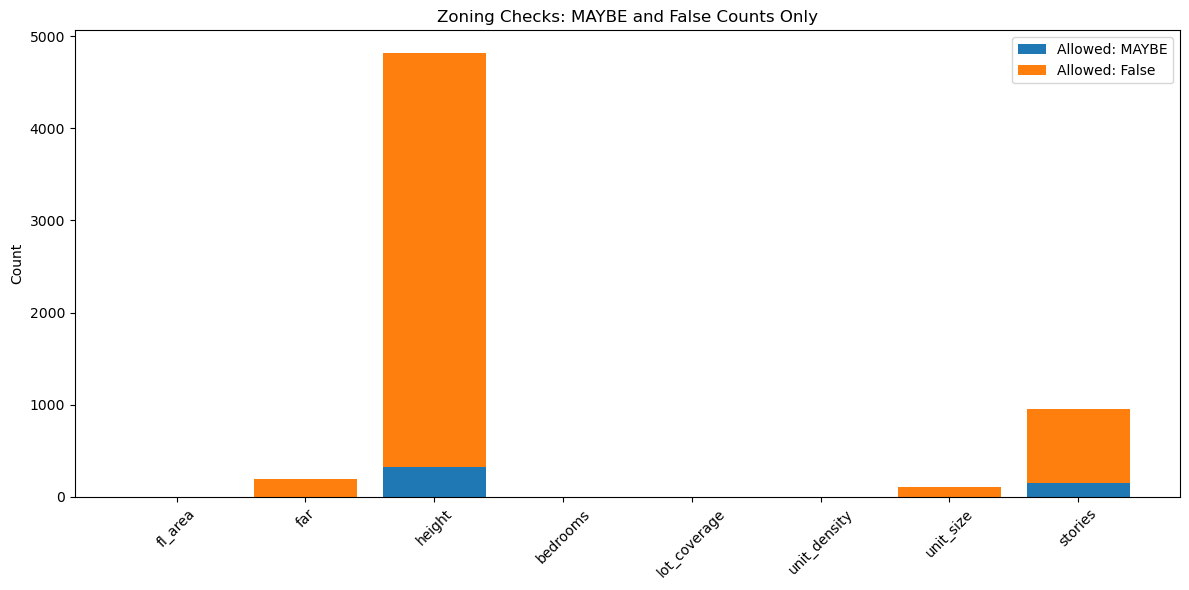

In [ ]:
# import pandas as pd

# # Suppose these are your pre-defined DataFrames for each check
# check_results = {
#     "height": check_height_result_all,
#     "height_eave": check_height_eave_result_all,
#     "stories": check_stories_result_all,
#     "unit_size": check_unit_size_result_all,
#     "far": check_far_result_all,
#     "unit_density": check_unit_density_result_all,
#     "lot_coverage": check_lot_coverage_result_all,
#     "fl_area": check_fl_area_result_all,
#     "bedrooms": check_bedrooms_result_all,
#     "unit_qty": check_unit_qty_result_all,
# }

# # Initialize the summary dictionary
# summary = {
#     "Label": [],
#     "True": [],
#     "False": [],
#     "MAYBE": []
# }

# # Iterate over the results and count each allowed status
# for label, df in check_results.items():
#     # Get value counts for the 'allowed' column
#     allowed_counts = df["allowed"].value_counts()
    
#     # Append the name and counts, with default to 0 if not found
#     summary["Label"].append(label)
#     summary["True"].append(allowed_counts.get(True, 0))
#     summary["False"].append(allowed_counts.get(False, 0))
#     summary["MAYBE"].append(allowed_counts.get("MAYBE", 0))

# # Convert the summary dictionary into a DataFrame
# summary_df = pd.DataFrame(summary)

# # Display the summary table
# print(summary_df)

### `add_setbacks` function
- `get_zoning_req` function is integrated internally.

In [49]:
file_path = r"/Users/houpuli/Dropbox/ceshi/tidybuilding/2_fam/"
tidybuilding_2_fam = unify_tidybuilding(file_path)
tidybuilding_2_fam

,stories,height,width,depth,height_eave,type,gross_fl_area,net_fl_area,max_unit_size,min_unit_size,mean_unit_size,total_bedrooms,total_units,footprint,units_3bed,units_3bed_minsize,units_3bed_maxsize,units_floor1,units_floor2,units_floor3
0,2.5,45,35,40,35,2_family,3200,3126,1563,1563,1563,6,2,1400,2,1563,1563,2,0,0


In [148]:
# Example usage:
add_setbacks_results = add_setbacks(tidybuilding_2_fam, tidyzoning_feeds.loc[[373]], tidyparcel_dim[tidyparcel_dim['parcel_id'] == 'Collin_County_combined_parcel_102719'], tidyparcel_geo[tidyparcel_geo['parcel_id'] == 'Collin_County_combined_parcel_102719'])
add_setbacks_results

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,...,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry,setback,unit,on_boundary
14139,2503294,R-5140-00E-0090-1,Collin_County_combined_parcel_102719,890 DERBY CT,R,A1,cul_de_sac parcel_other,True,Derby Ct,1.164104,...,False,-2.732984,-0.000002,23.411678,16.169501,front,"LINESTRING (1297967.613 1242664.136, 1297965.5...",10.0,feet,False
14140,2503294,R-5140-00E-0090-1,Collin_County_combined_parcel_102719,890 DERBY CT,R,A1,cul_de_sac parcel_other,True,Derby Ct,1.164104,...,True,-1.805070,-0.000002,76.577216,35.714161,Interior side,"LINESTRING (1297973.690 1242693.165, 1297973.6...",5.0,feet,False
14141,2503294,R-5140-00E-0090-1,Collin_County_combined_parcel_102719,890 DERBY CT,R,A1,cul_de_sac parcel_other,True,Derby Ct,1.164104,...,True,-0.006169,-0.000002,0.353327,53.093845,rear,"LINESTRING (1297937.939 1242692.349, 1297961.2...",20.0,feet,False
14142,2503294,R-5140-00E-0090-1,Collin_County_combined_parcel_102719,890 DERBY CT,R,A1,cul_de_sac parcel_other,True,Derby Ct,1.164104,...,True,1.577510,-0.000002,89.615248,31.418836,Interior side,"LINESTRING (1297939.234 1242656.113, 1297937.9...",5.0,feet,False
14143,2503294,R-5140-00E-0090-1,Collin_County_combined_parcel_102719,890 DERBY CT,R,A1,cul_de_sac parcel_other,True,Derby Ct,1.164104,...,False,-3.138775,-0.000002,0.161550,9.632050,front,"LINESTRING (1297951.203 1242656.493, 1297939.2...",10.0,feet,False


### `get_buildable_area` function
- `get_zoning_req` function is integrated internally.

In [ ]:
# Example usage:
add_setbacks_results = add_setbacks(tidybuilding_4_fam_wide, tidyzoning.loc[[2]], confident_tidyparcel_dim[confident_tidyparcel_dim['parcel_id'] == 'Collin_County_combined_parcel_10000'], confident_tidyparcel[confident_tidyparcel['parcel_id'] == 'Collin_County_combined_parcel_10000'])
add_setbacks_results

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,...,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry,setback,unit
0,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,True,-1.571972,-0.006727,89.681925,36.761265,Interior side,"LINESTRING (-10768051.845 3919309.968, -107680...","[20, 15]",feet
1,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,True,-0.003207,-0.006727,0.201640,62.382758,rear,"LINESTRING (-10768069.990 3919310.026, -107680...",25,feet
2,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,True,1.569623,-0.006727,89.681813,36.697407,Interior side,"LINESTRING (-10768070.050 3919258.718, -107680...","[20, 15]",feet
3,2747493,R-11137-00A-0150-1,Collin_County_combined_parcel_10000,8816 ABBINGTON PL,R,A1,regular inside parcel,True,Abbington Pl,1.284231,...,0.201639,False,3.138385,-0.006727,0.201639,11.075914,front,"LINESTRING (-10768051.905 3919258.660, -107680...","[50, 30]",feet


In [24]:
get_buildable_area_result = get_buildable_area(add_setbacks_results)
get_buildable_area_result

,Prop_ID,parcel_id,buildable_geometry_relaxable,buildable_geometry_strict
0,2747493,Collin_County_combined_parcel_10000,POLYGON ((-10768065.467793169 3919267.84744810...,"POLYGON ((-10768063.937 3919273.939, -10768063..."


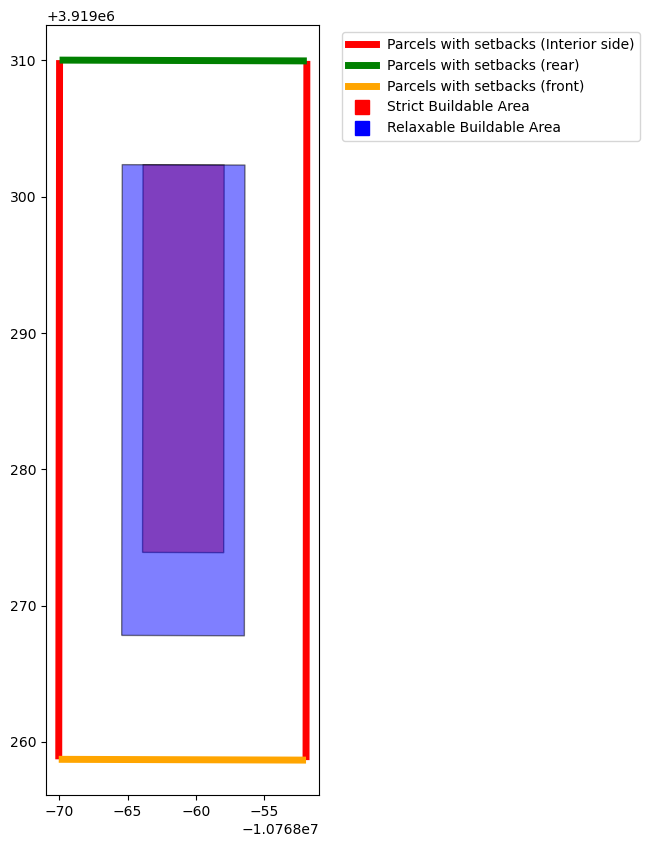

In [25]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Define a mapping from 'side' values to colors.
color_mapping = {
    'Interior side': 'red',
    'Exterior side': 'blue',
    'rear': 'green',
    'front': 'orange'
}

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the setbacks results by grouping based on the 'side' column.
for side, group in add_setbacks_results.groupby('side'):
    group.plot(
        ax=ax, 
        color=None, 
        alpha=1, 
        edgecolor=color_mapping.get(side, 'black'), 
        linewidth=5, 
        label=f'Parcels with setbacks ({side})'
    )

# Plot the strict buildable area.
strict_area = get_buildable_area_result.copy().set_geometry('buildable_geometry_strict')
strict_area.plot(
    ax=ax, 
    color='red', 
    alpha=0.5, 
    edgecolor='black', 
    label='Strict Buildable Area'
)

# Plot the relaxable buildable area.
relaxable_area = get_buildable_area_result.copy().set_geometry('buildable_geometry_relaxable')
relaxable_area.plot(
    ax=ax, 
    color='blue', 
    alpha=0.5, 
    edgecolor='black', 
    label='Relaxable Buildable Area'
)

# Create custom legend handles.
handles = []
# Add legend handles for each setbacks side.
for side in add_setbacks_results['side'].unique():
    color = color_mapping.get(side, 'black')
    handle = mlines.Line2D([], [], color=color, linewidth=5, label=f'Parcels with setbacks ({side})')
    handles.append(handle)
# Add handles for the buildable area layers.
handles.append(mlines.Line2D([], [], color='red', marker='s', markersize=10,
                             markerfacecolor='red', linestyle='None',
                             label='Strict Buildable Area'))
handles.append(mlines.Line2D([], [], color='blue', marker='s', markersize=10,
                             markerfacecolor='blue', linestyle='None',
                             label='Relaxable Buildable Area'))

ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(2.2, 1))
plt.show()

### `check_footprint()` function
- Based on Matt's Way

In [26]:
check_footprint_results = check_footprint(get_buildable_area_result, tidybuilding_4_fam_wide)
check_footprint_results

Processing Parcels: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


,Prop_ID,parcel_id,allowed
0,2747493,Collin_County_combined_parcel_10000,False


### Run Code by steps

### Run Code summariezed function

#### Statistic in each check function

##### Check the land use

In [23]:
from collections import Counter

# Extract uses_value, ensuring it is of list type
uses_values_list = tidyzoning['dist_info'].apply(
    lambda x: x.get('uses_permitted', {}).get('uses_value', [])
)

# Handle exceptional cases: if `uses_value` is a string, convert it to a list
cleaned_uses_values = uses_values_list.apply(lambda x: [x] if isinstance(x, str) else x)

# Calculate all unique uses_value
unique_uses_values = set(value for sublist in cleaned_uses_values for value in sublist)

# Count the occurrences of each uses_value
counts = Counter()
for uses in cleaned_uses_values:
    counts.update(uses)

# Create a DataFrame to calculate the percentage
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
counts_df['percentage'] = counts_df['count'] / len(tidyzoning) * 100
counts_df

,count,percentage
1_family,114,40.569395
ADU,103,36.654804
2_family,45,16.014235
3_family,44,15.658363
4_family,45,16.014235
Townhome,48,17.081851
none,115,40.925267
Planned_Residential_Development,11,3.914591


##### Check the fl_area

In [24]:
fl_area_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'fl_area' in key.lower()} if isinstance(x, dict) else {}
)
fl_area_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

##### Check the height

In [25]:
height_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'height' in key.lower()} if isinstance(x, dict) else {}
)
height_constraints

0                                                     {}
1                                                     {}
2                                                     {}
3                                                     {}
4                                                     {}
                             ...                        
276                                                   {}
277                                                   {}
278                                                   {}
279    {'height': [{'unit': 'feet', 'use_name': '1_fa...
280                                                   {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_24888\1675141653.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='height', data=filtered_df, palette="Set3")


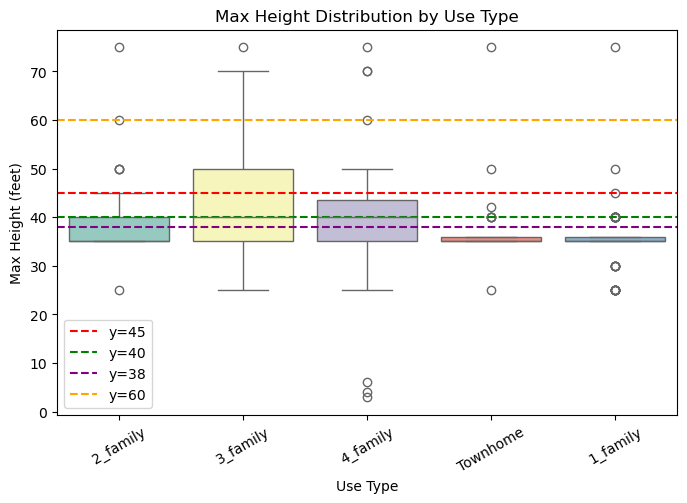

In [36]:
import seaborn as sns

# Step 1: Parse height data
height_data = []
for constraints in height_constraints:
    if isinstance(constraints, dict) and 'height' in constraints:
        for entry in constraints['height']:
            use_names = entry.get('use_name', [])
            max_val = entry.get('max_val')

            # Handle max_val: it could be a dictionary or a list
            if isinstance(max_val, list):  # Handle case where max_val is a list
                max_val = max_val[0] if len(max_val) > 0 else {}
            
            # Extract height value
            if isinstance(max_val, dict):
                if 'expression' in max_val:
                    height_value = max_val['expression']
                elif 'expressions' in max_val:
                    height_value = max(max_val['expressions'])  # Take the maximum value
                else:
                    height_value = None
            else:
                height_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if height_value:
                for use in use_names:
                    try:
                        height_data.append({'use_name': use, 'height': float(height_value)})
                    except ValueError:
                        pass  # Ignore values that cannot be converted

# Step 2: Convert to DataFrame
height_df = pd.DataFrame(height_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = height_df[height_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='height', data=filtered_df, palette="Set3")

# Step 5: Add reference lines
for y_value, color, label in zip([45, 40, 38, 60], ['red', 'green', 'purple', 'orange'], ['y=45', 'y=40', 'y=38', 'y=60']):
    plt.axhline(y=y_value, color=color, linestyle='--', label=label)

# Step 6: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Max Height (feet)")
plt.title("Max Height Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the bedrooms

In [37]:
bedrooms_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'bedrooms' in key.lower()} if isinstance(x, dict) else {}
)
bedrooms_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

##### Check the unit density

In [26]:
unit_density_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'unit_density' in key.lower()} if isinstance(x, dict) else {}
)
unit_density_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_24888\2265464215.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='unit_density', data=filtered_df, palette="Set3")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


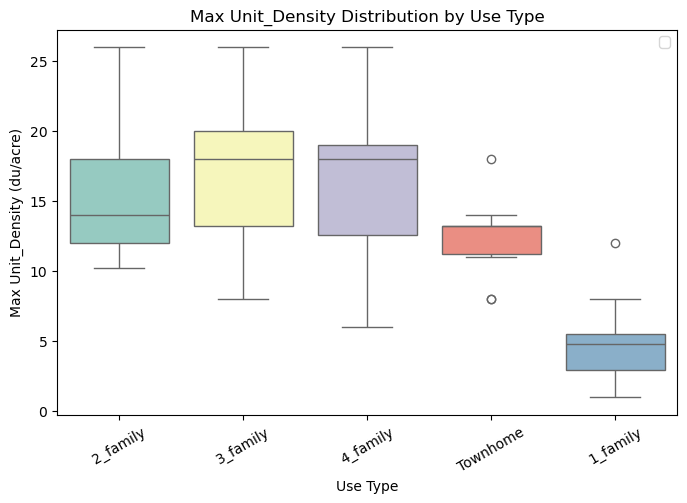

In [39]:
import seaborn as sns

# Step 1: Parse unit_density data
unit_density_data = []
for constraints in unit_density_constraints:
    if isinstance(constraints, dict) and 'unit_density' in constraints:
        for entry in constraints['unit_density']:
            use_names = entry.get('use_name', [])
            max_val = entry.get('max_val')

            # Handle max_val: it could be a dictionary or a list
            if isinstance(max_val, list):  # Handle case where max_val is a list
                max_val = max_val[0] if len(max_val) > 0 else {}
            
            # Extract unit_density value
            if isinstance(max_val, dict):
                if 'expression' in max_val:
                    unit_density_value = max_val['expression']
                elif 'expressions' in max_val:
                    unit_density_value = max(max_val['expressions'])  # Take the maximum value
                else:
                    unit_density_value = None
            else:
                unit_density_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if unit_density_value:
                for use in use_names:
                    try:
                        unit_density_data.append({'use_name': use, 'unit_density': float(unit_density_value)})
                    except ValueError:
                        pass  # Ignore values that cannot be converted

# Step 2: Convert to DataFrame
unit_density_df = pd.DataFrame(unit_density_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = unit_density_df[unit_density_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='unit_density', data=filtered_df, palette="Set3")

# Step 5: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Max Unit_Density (du/acre)")
plt.title("Max Unit_Density Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the unit size

In [27]:
unit_size_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'unit_size' in key.lower()} if isinstance(x, dict) else {}
)
unit_size_constraints

0      {'unit_size': [{'unit': 'square feet', 'use_na...
1      {'unit_size': [{'unit': 'square feet', 'use_na...
2      {'unit_size': [{'unit': 'square feet', 'use_na...
3                                                     {}
4                                                     {}
                             ...                        
276                                                   {}
277                                                   {}
278                                                   {}
279                                                   {}
280                                                   {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_24888\513548288.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='unit_size', data=filtered_df, palette="Set3")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


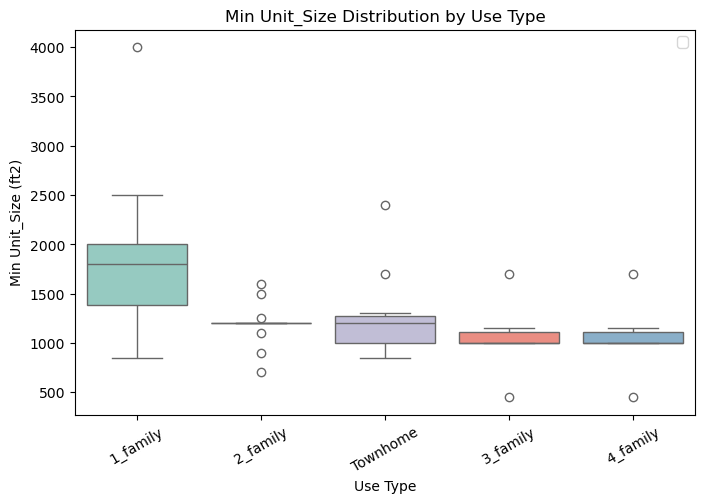

In [41]:
import seaborn as sns
import re

# Step 1: Parse unit_size data
unit_size_data = []
bedrooms = 6  # Default bedrooms=6

for constraints in unit_size_constraints:
    if isinstance(constraints, dict) and 'unit_size' in constraints:
        for entry in constraints['unit_size']:
            use_names = entry.get('use_name', [])
            min_val = entry.get('min_val')

            # Handle min_val: it could be a dictionary or a list
            if isinstance(min_val, list):  
                min_val = min_val[0] if len(min_val) > 0 else {}

            # Extract expression
            if isinstance(min_val, dict) and 'expression' in min_val:
                raw_expr = min_val['expression']
                
                # Skip "NA" values
                if raw_expr == 'NA':
                    continue
                
                # Handle "0/1 BR: 600; 2 BR: 800; 3BR: 1000"
                if re.search(r'3BR:\s*\d+', raw_expr):
                    match = re.search(r'3BR:\s*(\d+)', raw_expr)
                    unit_size_value = float(match.group(1)) if match else None
                
                # Handle "800 + 150 * bedrooms" calculation
                elif re.search(r'bedrooms', raw_expr):
                    try:
                        unit_size_value = eval(raw_expr.replace("bedrooms", str(bedrooms)))
                    except:
                        unit_size_value = None
                
                # Handle regular numeric values
                else:
                    try:
                        unit_size_value = float(raw_expr)
                    except ValueError:
                        unit_size_value = None
            else:
                unit_size_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if unit_size_value:
                for use in use_names:
                    try:
                        unit_size_data.append({'use_name': use, 'unit_size': unit_size_value})
                    except ValueError:
                        pass  # Ignore values that cannot be converted
                    
# Step 2: Convert to DataFrame
unit_size_df = pd.DataFrame(unit_size_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = unit_size_df[unit_size_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='unit_size', data=filtered_df, palette="Set3")

# Step 5: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Min Unit_Size (ft2)")
plt.title("Min Unit_Size Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the Far

In [28]:
far_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'far' in key.lower()} if isinstance(x, dict) else {}
)
far_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_24888\2235503832.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='far', data=filtered_df, palette="Set3")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


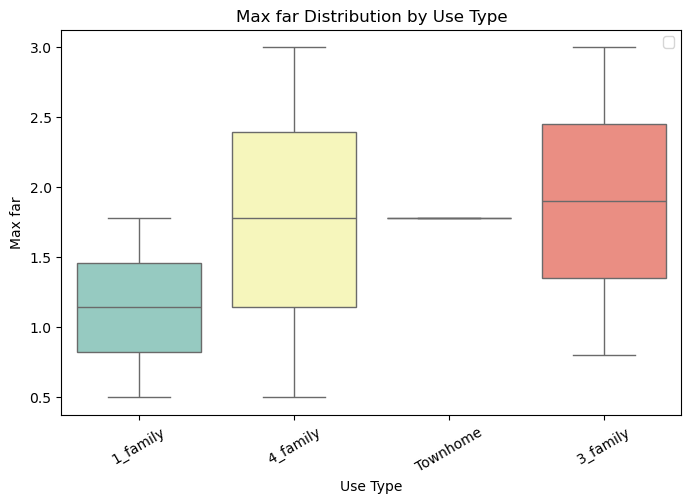

In [43]:
import seaborn as sns

# Step 1: Parse far data
far_data = []
for constraints in far_constraints:
    if isinstance(constraints, dict) and 'far' in constraints:
        for entry in constraints['far']:
            use_names = entry.get('use_name', [])
            max_val = entry.get('max_val')

            # Handle max_val: it could be a dictionary or a list
            if isinstance(max_val, list):  # Handle case where max_val is a list
                max_val = max_val[0] if len(max_val) > 0 else {}
            
            # Extract far value
            if isinstance(max_val, dict):
                if 'expression' in max_val:
                    far_value = max_val['expression']
                elif 'expressions' in max_val:
                    far_value = max(max_val['expressions'])  # Take the maximum value
                else:
                    far_value = None
            else:
                far_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if far_value:
                for use in use_names:
                    try:
                        far_data.append({'use_name': use, 'far': float(far_value)})
                    except ValueError:
                        pass  # Ignore values that cannot be converted

# Step 2: Convert to DataFrame
far_df = pd.DataFrame(far_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = far_df[far_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='far', data=filtered_df, palette="Set3")

# Step 5: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Max far")
plt.title("Max far Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the Lot_coverage

In [29]:
lot_coverage_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'lot_coverage' in key.lower()} if isinstance(x, dict) else {}
)
lot_coverage_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

### `zoning_analysis_pipeline` functions  

- 00.check_land_use
- 01.check_height
- 02.check_stories
- 03.check_unit_size
- 04.check_far
- 05.check_unit_density
- 06.check_bedrooms
- 07.check_lot_coverage
- 08.check_fl_area

In [9]:
tidybuilding_4_famtall_result_25 = zoning_analysis_pipeline(tidybuilding_4_fam_wide, part_tidyzoning_3081, tidyparcel_3081, confident_tidyparcel_3081,
                                                            detailed_check = False,
                                                            run_check_footprint = True)

tidybuilding_4_famtall_result_25

check_land_use: 14068 / 345350 parcels allowed (4.1%)
check_land_use runtime: 0.0 sec


Running check_height: 100%|██████████| 14068/14068 [24:02<00:00,  9.75it/s]  


check_height          Survive: 14068/14068 (100.0%)True: 9249 ( 65.7%)MAYBE:  327 (  2.3%)False: 4492 ( 31.9%)
check_height runtime: 1443.3 sec


Running check_height_eave: 100%|██████████| 9576/9576 [16:28<00:00,  9.69it/s]  


check_height_eave     Survive: 9576/14068 ( 68.1%)True: 9576 ( 68.1%)MAYBE:    0 (  0.0%)False:    0 (  0.0%)
check_height_eave runtime: 988.5 sec


Running check_stories: 100%|██████████| 9576/9576 [00:14<00:00, 668.17it/s]


check_stories         Survive: 9576/14068 ( 68.1%)True: 9142 ( 65.0%)MAYBE:  103 (  0.7%)False:  331 (  2.4%)
check_stories runtime: 14.3 sec


Running check_unit_size: 100%|██████████| 9245/9245 [00:29<00:00, 312.27it/s]


check_unit_size       Survive: 9245/14068 ( 65.7%)True: 8737 ( 62.1%)MAYBE:    3 (  0.0%)False:  505 (  3.6%)
check_unit_size runtime: 29.6 sec


Running check_far: 100%|██████████| 8740/8740 [14:51<00:00,  9.80it/s]  


check_far             Survive: 8740/14068 ( 62.1%)True: 8708 ( 61.9%)MAYBE:    0 (  0.0%)False:   32 (  0.2%)
check_far runtime: 891.6 sec


Running check_unit_density: 100%|██████████| 8708/8708 [00:12<00:00, 685.97it/s]


check_unit_density    Survive: 8708/14068 ( 61.9%)True: 8120 ( 57.7%)MAYBE:    0 (  0.0%)False:  588 (  4.2%)
check_unit_density runtime: 12.7 sec


Running check_lot_coverage: 100%|██████████| 8120/8120 [13:58<00:00,  9.69it/s]  


check_lot_coverage    Survive: 8120/14068 ( 57.7%)True: 7671 ( 54.5%)MAYBE:    3 (  0.0%)False:  446 (  3.2%)
check_lot_coverage runtime: 838.1 sec


Running check_fl_area: 100%|██████████| 7674/7674 [13:21<00:00,  9.58it/s]  


check_fl_area         Survive: 7674/14068 ( 54.5%)True: 7674 ( 54.5%)MAYBE:    0 (  0.0%)False:    0 (  0.0%)
check_fl_area runtime: 801.3 sec


Running check_unit_qty: 100%|██████████| 7674/7674 [13:00<00:00,  9.83it/s]  


check_unit_qty        Survive: 7674/14068 ( 54.5%)True: 7669 ( 54.5%)MAYBE:    0 (  0.0%)False:    5 (  0.0%)
check_unit_qty runtime: 780.9 sec
Running check_footprint on 7669/14068 parcels


check_footprint: 100%|██████████| 7669/7669 [19:44<00:00,  6.48it/s]  


check_footprint       Survive: 6147/14068 ( 43.7%)  True: 6062 ( 43.1%)  MAYBE:   85 (  0.6%)  False: 1522 ( 10.8%)
check_footprint runtime: 1184.4 sec
zoning_analysis_pipeline total runtime: 6989.0 sec
5954 / 345350 parcels fit the building
193 / 345350 parcels maybe fit the building


,Prop_ID,parcel_id,Parcel_label,lot_width,lot_depth,lot_area,zoning_id,confidence,check_land_use,check_height,...,check_far,check_unit_density,check_lot_coverage,check_fl_area,check_unit_qty,has_false,has_maybe,allowed,reason,check_footprint
0,2747493,Collin_County_combined_parcel_10000,regular inside parcel,49.798850,140.149905,0.160223,1318,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
1,2702267,Collin_County_combined_parcel_100028,special parcel_standard,92.356753,155.462562,0.330331,1462,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
2,2082442,Collin_County_combined_parcel_100030,regular inside parcel,75.976481,153.355275,0.257746,1318,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
3,2129279,Collin_County_combined_parcel_100049,regular inside parcel,88.756216,120.637375,0.244816,1451,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
4,1262715,Collin_County_combined_parcel_100067,regular corner parcel,72.942981,115.924629,0.194107,412,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345345,781626.0,Wise_County_combined_parcel_48085,regular corner parcel,99.861634,69.713292,0.159818,168,confidence_parcel,True,True,...,True,True,True,True,True,0,0,True,parcels fit the building,True
345346,746915.0,Wise_County_combined_parcel_647,regular corner parcel,334.613968,259.647001,1.991946,168,confidence_parcel,True,True,...,True,True,True,True,True,0,0,True,parcels fit the building,True
345347,753228.0,Wise_County_combined_parcel_7455,regular inside parcel,218.694540,100.216355,0.433263,273,confidence_parcel,True,True,...,True,True,True,True,True,0,0,True,parcels fit the building,True
345348,790473.0,Wise_County_combined_parcel_8586,regular corner parcel,771.376098,938.497464,5.223278,71,confidence_parcel,True,True,...,True,True,True,True,True,0,0,True,parcels fit the building,True


In [52]:
# Merge the output cvs DataFrame with the geometry from tidyparcel_geo_feeds
tidybuilding_4_famtall_result_25_geo = tidybuilding_4_famtall_result_25.merge(confident_tidyparcel_3081[confident_tidyparcel_3081['side'] == 'centroid'][['parcel_id', 'geometry']], on='parcel_id', how='left')

# Convert the merged DataFrame into a GeoDataFrame
tidybuilding_4_famtall_result_25_geo = gpd.GeoDataFrame(tidybuilding_4_famtall_result_25_geo, geometry='geometry', crs=confident_tidyparcel_3081.crs)
tidybuilding_4_famtall_result_25_geo

,Prop_ID,parcel_id,Parcel_label,lot_width,lot_depth,lot_area,zoning_id,confidence,check_land_use,check_height,...,check_unit_density,check_lot_coverage,check_fl_area,check_unit_qty,has_false,has_maybe,allowed,reason,check_footprint,geometry
0,2747493,Collin_County_combined_parcel_10000,regular inside parcel,49.798850,140.149905,0.160223,1318,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1304352.385 1227377.002)
1,2702267,Collin_County_combined_parcel_100028,special parcel_standard,92.356753,155.462562,0.330331,1462,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1301782.829 1235316.501)
2,2082442,Collin_County_combined_parcel_100030,regular inside parcel,75.976481,153.355275,0.257746,1318,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1304719.267 1229367.106)
3,2129279,Collin_County_combined_parcel_100049,regular inside parcel,88.756216,120.637375,0.244816,1451,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1298876.961 1232769.797)
4,1262715,Collin_County_combined_parcel_100067,regular corner parcel,72.942981,115.924629,0.194107,412,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1300524.041 1205829.726)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345345,781626.0,Wise_County_combined_parcel_48085,regular corner parcel,99.861634,69.713292,0.159818,168,confidence_parcel,True,True,...,True,True,True,True,0,0,True,parcels fit the building,True,POINT (1208823.978 1228219.939)
345346,746915.0,Wise_County_combined_parcel_647,regular corner parcel,334.613968,259.647001,1.991946,168,confidence_parcel,True,True,...,True,True,True,True,0,0,True,parcels fit the building,True,POINT (1208451.850 1229796.569)
345347,753228.0,Wise_County_combined_parcel_7455,regular inside parcel,218.694540,100.216355,0.433263,273,confidence_parcel,True,True,...,True,True,True,True,0,0,True,parcels fit the building,True,POINT (1204553.755 1237961.482)
345348,790473.0,Wise_County_combined_parcel_8586,regular corner parcel,771.376098,938.497464,5.223278,71,confidence_parcel,True,True,...,True,True,True,True,0,0,True,parcels fit the building,True,POINT (1234189.059 1210485.729)


In [46]:
tidybuilding_4_famtall_result_25_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 345350 entries, 0 to 345349
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Prop_ID             344845 non-null  object  
 1   parcel_id           345350 non-null  object  
 2   Parcel_label        345350 non-null  object  
 3   lot_width           345350 non-null  float64 
 4   lot_depth           345350 non-null  float64 
 5   lot_area            345350 non-null  float64 
 6   zoning_id           345350 non-null  int64   
 7   confidence          345350 non-null  object  
 8   check_land_use      345350 non-null  bool    
 9   check_height        14068 non-null   object  
 10  check_height_eave   9576 non-null    object  
 11  check_stories       9576 non-null    object  
 12  check_unit_size     9245 non-null    object  
 13  check_far           8740 non-null    object  
 14  check_unit_density  8708 non-null    object  
 15  check_lot

In [53]:
tidybuilding_4_famtall_result_25_geo.to_csv(r"/Users/houpuli/Dropbox/ceshi/tidybuilding_4_famtall_result_25_geo.csv", index=False)

In [10]:
tidybuilding_4_famtall_result_df = zoning_analysis_pipeline(tidybuilding_4_fam_wide, tidyzoning_feeds, tidyparcel_dim_feeds, tidyparcel_geo_feeds,
                                                            detailed_check = False,
                                                            run_check_footprint = True)
tidybuilding_4_famtall_result_df

check_land_use: 101861 / 1953251 parcels allowed (5.2%)
check_land_use runtime: 0.0 sec


Running check_height: 100%|██████████| 101861/101861 [2:53:40<00:00,  9.77it/s]  


check_height          Survive: 101861/101861 (100.0%)True: 74699 ( 73.3%)MAYBE: 2583 (  2.5%)False: 24579 ( 24.1%)
check_height runtime: 10420.7 sec


Running check_height_eave: 100%|██████████| 77282/77282 [2:10:06<00:00,  9.90it/s]   


check_height_eave     Survive: 77282/101861 ( 75.9%)True: 77193 ( 75.8%)MAYBE:   89 (  0.1%)False:    0 (  0.0%)
check_height_eave runtime: 7806.8 sec


Running check_stories: 100%|██████████| 77282/77282 [01:48<00:00, 715.01it/s] 


check_stories         Survive: 77282/101861 ( 75.9%)True: 72771 ( 71.4%)MAYBE:  918 (  0.9%)False: 3593 (  3.5%)
check_stories runtime: 108.1 sec


Running check_unit_size: 100%|██████████| 73689/73689 [03:43<00:00, 330.16it/s]


check_unit_size       Survive: 73689/101861 ( 72.3%)True: 71632 ( 70.3%)MAYBE:  102 (  0.1%)False: 1955 (  1.9%)
check_unit_size runtime: 223.2 sec


Running check_far: 100%|██████████| 71734/71734 [2:01:06<00:00,  9.87it/s]   


check_far             Survive: 71734/101861 ( 70.4%)True: 71509 ( 70.2%)MAYBE:   89 (  0.1%)False:  136 (  0.1%)
check_far runtime: 7266.9 sec


Running check_unit_density: 100%|██████████| 71598/71598 [01:39<00:00, 722.50it/s] 


check_unit_density    Survive: 71598/101861 ( 70.3%)True: 66728 ( 65.5%)MAYBE:  105 (  0.1%)False: 4765 (  4.7%)
check_unit_density runtime: 99.1 sec


Running check_lot_coverage: 100%|██████████| 66833/66833 [1:52:28<00:00,  9.90it/s]  


check_lot_coverage    Survive: 66833/101861 ( 65.6%)True: 62904 ( 61.8%)MAYBE:  104 (  0.1%)False: 3825 (  3.8%)
check_lot_coverage runtime: 6749.0 sec


Running check_fl_area: 100%|██████████| 63008/63008 [1:46:09<00:00,  9.89it/s]  


check_fl_area         Survive: 63008/101861 ( 61.9%)True: 62919 ( 61.8%)MAYBE:   89 (  0.1%)False:    0 (  0.0%)
check_fl_area runtime: 6369.6 sec


Running check_unit_qty: 100%|██████████| 63008/63008 [1:46:40<00:00,  9.84it/s]  


check_unit_qty        Survive: 63008/101861 ( 61.9%)True: 62877 ( 61.7%)MAYBE:   89 (  0.1%)False:   42 (  0.0%)
check_unit_qty runtime: 6400.9 sec
Running check_footprint on 45236/101861 parcels


check_footprint: 100%|██████████| 45236/45236 [4:53:30<00:00,  2.57it/s]   


check_footprint       Survive: 37740/101861 ( 37.1%)  True: 37209 ( 36.5%)  MAYBE:  531 (  0.5%)  False: 7496 (  7.4%)
check_footprint runtime: 17610.5 sec
zoning_analysis_pipeline total runtime: 63078.8 sec
36863 / 1953251 parcels fit the building
18607 / 1953251 parcels maybe fit the building


,prop_ID,parcel_id,parcel_label,lot_width,lot_depth,lot_area,zoning_id,confidence,check_land_use,check_height,...,check_far,check_unit_density,check_lot_coverage,check_fl_area,check_unit_qty,has_false,has_maybe,allowed,reason,check_footprint
0,2577028,Collin_County_combined_parcel_1,regular inside parcel,58.298893,110.904141,0.133264,12,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
1,2593811,Collin_County_combined_parcel_10,regular inside parcel,68.062373,125.157973,0.190673,489,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
2,1755568,Collin_County_combined_parcel_1000,regular inside parcel,84.851943,139.290933,0.228002,349,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
3,2747493,Collin_County_combined_parcel_10000,regular inside parcel,49.798850,140.149905,0.160223,2150,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
4,1827401,Collin_County_combined_parcel_100000,regular inside parcel,45.696737,95.492286,0.098509,172,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953246,754624.0,Wise_County_combined_parcel_9374,special parcel_other,1.000000,1.000000,0.060597,1665,non_confidence_parcel,True,True,...,True,True,True,True,True,0,0,MAYBE,"Initial check passed, but no footprint check",NaN
1953247,770698.0,Wise_County_combined_parcel_9383,regular corner parcel,125.411803,120.021121,0.344533,2090,confidence_parcel,True,True,...,True,True,True,True,True,0,1,MAYBE,"MAYBE encountered: check_stories, check_footprint",MAYBE
1953248,733937.0,Wise_County_combined_parcel_9450,regular corner parcel,105.567961,57.520230,0.135661,1665,confidence_parcel,True,True,...,True,True,True,True,True,0,0,False,FALSE encountered: check_footprint,False
1953249,732684.0,Wise_County_combined_parcel_9591,duplicated address,1.000000,1.000000,1.049195,834,non_confidence_parcel,True,True,...,True,True,True,True,True,0,0,MAYBE,"Initial check passed, but no footprint check",NaN


In [54]:
# Merge the output cvs DataFrame with the geometry from tidyparcel_geo_feeds
tidybuilding_4_famtall_result_df_geo = tidybuilding_4_famtall_result_df.merge(tidyparcel_geo_feeds[tidyparcel_geo_feeds['side'] == 'centroid'][['parcel_id', 'geometry']], on='parcel_id', how='left')

# Convert the merged DataFrame into a GeoDataFrame
tidybuilding_4_famtall_result_df_geo = gpd.GeoDataFrame(tidybuilding_4_famtall_result_df_geo, geometry='geometry', crs=tidyparcel_geo_feeds.crs)
tidybuilding_4_famtall_result_df_geo

,prop_ID,parcel_id,parcel_label,lot_width,lot_depth,lot_area,zoning_id,confidence,check_land_use,check_height,...,check_unit_density,check_lot_coverage,check_fl_area,check_unit_qty,has_false,has_maybe,allowed,reason,check_footprint,geometry
0,2577028,Collin_County_combined_parcel_1,regular inside parcel,58.298893,110.904141,0.133264,12,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1322569.833 1229621.524)
1,2593811,Collin_County_combined_parcel_10,regular inside parcel,68.062373,125.157973,0.190673,489,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1298633.220 1227254.211)
2,1755568,Collin_County_combined_parcel_1000,regular inside parcel,84.851943,139.290933,0.228002,349,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1304981.109 1215980.212)
3,2747493,Collin_County_combined_parcel_10000,regular inside parcel,49.798850,140.149905,0.160223,2150,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1304352.385 1227377.002)
4,1827401,Collin_County_combined_parcel_100000,regular inside parcel,45.696737,95.492286,0.098509,172,confidence_parcel,False,NaN,...,NaN,NaN,NaN,NaN,1,0,False,FALSE encountered: check_land_use,NaN,POINT (1298793.461 1207578.341)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953246,754624.0,Wise_County_combined_parcel_9374,special parcel_other,1.000000,1.000000,0.060597,1665,non_confidence_parcel,True,True,...,True,True,True,True,0,0,MAYBE,"Initial check passed, but no footprint check",NaN,POINT (1208255.855 1228277.121)
1953247,770698.0,Wise_County_combined_parcel_9383,regular corner parcel,125.411803,120.021121,0.344533,2090,confidence_parcel,True,True,...,True,True,True,True,0,1,MAYBE,"MAYBE encountered: check_stories, check_footprint",MAYBE,POINT (1215487.467 1221620.259)
1953248,733937.0,Wise_County_combined_parcel_9450,regular corner parcel,105.567961,57.520230,0.135661,1665,confidence_parcel,True,True,...,True,True,True,True,0,0,False,FALSE encountered: check_footprint,False,POINT (1209110.801 1227635.442)
1953249,732684.0,Wise_County_combined_parcel_9591,duplicated address,1.000000,1.000000,1.049195,834,non_confidence_parcel,True,True,...,True,True,True,True,0,0,MAYBE,"Initial check passed, but no footprint check",NaN,POINT (1223809.623 1230025.664)


In [55]:
tidybuilding_4_famtall_result_df_geo.to_csv(r"/Users/houpuli/Dropbox/ceshi/tidybuilding_4_famtall_result_df_geo.csv", index=False)

### Debugging the process

In [45]:
kamryn_results = pd.read_csv(r"/Users/houpuli/Dropbox/ceshi/all_checks_25_pct_lu_TRUE.csv")
kamryn_results['zoning_id'] = kamryn_results['zoning_id'] - 1
kamryn_results

,Unnamed: 0,Prop_ID,parcel_id,Parcel_label,lot_width,lot_depth,lot_area,zoning_id,check_land_use,check_height,check_height_eave,check_floors,check_unit_size,check_far,check_unit_density,check_lot_coverage,check_fl_area,check_unit_qty
0,1.240000,1140143,Collin_County_combined_parcel_100303,regular inside parcel,60.377629,57.094367,0.078207,1319,True,TRUE,True,TRUE,TRUE,True,TRUE,TRUE,True,True
1,1.540000,2712455,Collin_County_combined_parcel_10067,regular inside parcel,48.491800,119.395533,0.132909,1319,True,TRUE,True,TRUE,TRUE,True,TRUE,TRUE,True,True
2,1.570000,2529683,Collin_County_combined_parcel_100752,special parcel_standard,43.442223,131.532296,0.127566,1761,True,TRUE,True,TRUE,FALSE,True,FALSE,TRUE,True,True
3,1.134000,1105725,Collin_County_combined_parcel_101602,regular inside parcel,129.624525,141.769853,0.416691,1319,True,TRUE,True,TRUE,TRUE,True,TRUE,TRUE,True,True
4,1.208000,2529792,Collin_County_combined_parcel_102471,regular inside parcel,44.287817,137.043459,0.134441,1761,True,TRUE,True,TRUE,FALSE,True,FALSE,TRUE,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14063,7.345223,781626,Wise_County_combined_parcel_48085,regular corner parcel,119.416309,83.757465,0.229614,168,True,TRUE,True,TRUE,TRUE,True,TRUE,TRUE,True,True
14064,7.345287,746915,Wise_County_combined_parcel_647,regular corner parcel,400.201694,312.001538,2.862745,168,True,TRUE,True,TRUE,TRUE,True,TRUE,TRUE,True,True
14065,7.345313,753228,Wise_County_combined_parcel_7455,regular inside parcel,261.767899,120.502010,0.623661,273,True,TRUE,True,TRUE,TRUE,True,TRUE,TRUE,True,True
14066,7.345331,790473,Wise_County_combined_parcel_8586,regular corner parcel,920.796514,1122.352092,7.477974,71,True,TRUE,True,TRUE,TRUE,True,TRUE,TRUE,True,True


In [46]:
cols = [
    'check_land_use', 'check_height', 'check_height_eave', 'check_floors',
    'check_unit_size', 'check_far', 'check_unit_density', 'check_lot_coverage',
    'check_fl_area', 'check_unit_qty'
]
kamryn_results[cols] = kamryn_results[cols].applymap(lambda x: str(x).upper())
statistic_results = pd.DataFrame(index=["TRUE", "FALSE", "MAYBE"])

for col in cols:
    count_series = kamryn_results[col].value_counts()
    statistic_results[col] = count_series

statistic_results = statistic_results.fillna(0).astype(int)
statistic_results = statistic_results.transpose()
statistic_results

/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/ipykernel_1298/1597969407.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  kamryn_results[cols] = kamryn_results[cols].applymap(lambda x: str(x).upper())


,TRUE,FALSE,MAYBE
check_land_use,14068,0,0
check_height,9249,4492,327
check_height_eave,14068,0,0
check_floors,13113,805,150
check_unit_size,13442,623,3
check_far,13869,199,0
check_unit_density,12240,1824,4
check_lot_coverage,13012,1049,7
check_fl_area,14068,0,0
check_unit_qty,14062,6,0


In [66]:
cols = [
    'check_land_use', 'check_height', 'check_height_eave', 'check_floors',
    'check_unit_size', 'check_far', 'check_unit_density',
    'check_lot_coverage', 'check_fl_area', 'check_unit_qty'
]

# create a boolean DataFrame marking True wherever the cell is True (or the string 'True')
checks_bool = kamryn_results[cols].applymap(lambda x: x is True or x == 'TRUE')

# count how many rows have every column True
count_all_true = checks_bool.all(axis=1).sum()

print(f"{count_all_true} rows have all {len(cols)} checks == TRUE")

7712 rows have all 10 checks == TRUE


/var/folders/s5/1g0kvw1x37z1n8xgxcp8f3lh0000gn/T/ipykernel_1298/644753729.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  checks_bool = kamryn_results[cols].applymap(lambda x: x is True or x == 'TRUE')


In [18]:
compare_id_differences(check_lot_coverage_result_all, kamryn_results, kamryn_filter_col='check_lot_coverage')

Only in the first dataset for zoning_id: set()
Only in kamryn_results for zoning_id: set()
Only in the first dataset for parcel_id: set()
Only in kamryn_results for parcel_id: set()


In [ ]:
draft_check = zoning_analysis_pipeline(tidybuilding_4_fam_wide, tidyzoning_3857, tidyparcel_3857, confident_tidyparcel_3857, n_jobs=12, debug=True)
draft_check

Parcel count: total 345350 parcels,
14068 passed land use check; others marked as check_land_use=False.
Percentage remaining: 4.07%.


Processing Allowed Parcels: 100%|██████████| 14068/14068 [11:50<00:00, 19.80it/s]


,Prop_ID,parcel_id,zoning_id,allowed,reason,check_process
14068,2747493,Collin_County_combined_parcel_10000,1318,False,check_land_use,{'check_land_use': False}
14069,2702267,Collin_County_combined_parcel_100028,1462,False,check_land_use,{'check_land_use': False}
14070,2082442,Collin_County_combined_parcel_100030,1318,False,check_land_use,{'check_land_use': False}
14071,2129279,Collin_County_combined_parcel_100049,1451,False,check_land_use,{'check_land_use': False}
14072,1262715,Collin_County_combined_parcel_100067,412,False,check_land_use,{'check_land_use': False}
...,...,...,...,...,...,...
345346,783763.0,Wise_County_combined_parcel_9058,66,False,check_land_use,{'check_land_use': False}
14067,783634.0,Wise_County_combined_parcel_9195,169,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."
345347,755021.0,Wise_County_combined_parcel_9452,171,False,check_land_use,{'check_land_use': False}
345348,753256.0,Wise_County_combined_parcel_9590,270,False,check_land_use,{'check_land_use': False}


In [20]:
initial_check = draft_check[draft_check['allowed'] == True]
initial_check

,Prop_ID,parcel_id,zoning_id,allowed,reason,check_process
0,1140143,Collin_County_combined_parcel_100303,1319,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."
1,2712455,Collin_County_combined_parcel_10067,1319,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."
3,1105725,Collin_County_combined_parcel_101602,1319,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."
7,1326443,Collin_County_combined_parcel_104198,1319,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."
8,2107181,Collin_County_combined_parcel_104734,1319,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."
...,...,...,...,...,...,...
14063,781626.0,Wise_County_combined_parcel_48085,168,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."
14064,746915.0,Wise_County_combined_parcel_647,168,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."
14065,753228.0,Wise_County_combined_parcel_7455,273,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."
14066,790473.0,Wise_County_combined_parcel_8586,71,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."


In [23]:
kamryn_final_result2 = pd.read_csv(r'/Users/houpuli/Dropbox/ceshi/check_footprint_25_pct.csv')
kamryn_final_result2['zoning_id'] = kamryn_final_result2['zoning_id'] -1
kamryn_final_result2

,Prop_ID,parcel_id,Parcel_label,lot_width,lot_depth,lot_area,zoning_id,check_land_use,check_height,check_height_eave,check_floors,check_unit_size,check_far,check_unit_density,check_lot_coverage,check_fl_area,bldg_area,check_footprint_area,check_footprint
0,1140143,Collin_County_combined_parcel_100303,regular inside parcel,60.377629,57.094367,0.078207,1319,True,True,True,True,True,True,True,True,True,2496,True,TRUE
1,2712455,Collin_County_combined_parcel_10067,regular inside parcel,48.491800,119.395533,0.132909,1319,True,True,True,True,True,True,True,True,True,2496,True,TRUE
2,1105725,Collin_County_combined_parcel_101602,regular inside parcel,129.624525,141.769853,0.416691,1319,True,True,True,True,True,True,True,True,True,2496,True,TRUE
3,1326443,Collin_County_combined_parcel_104198,regular corner parcel,78.757869,141.739173,0.256268,1319,True,True,True,True,True,True,True,True,True,2496,True,TRUE
4,2107181,Collin_County_combined_parcel_104734,regular corner parcel,125.414149,152.311911,0.437292,1319,True,True,True,True,True,True,True,True,True,2496,True,TRUE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7588,781626,Wise_County_combined_parcel_48085,regular corner parcel,119.416309,83.757465,0.229614,168,True,True,True,True,True,True,True,True,True,2496,True,FALSE
7589,746915,Wise_County_combined_parcel_647,regular corner parcel,400.201694,312.001538,2.862745,168,True,True,True,True,True,True,True,True,True,2496,True,TRUE
7590,753228,Wise_County_combined_parcel_7455,regular inside parcel,261.767899,120.502010,0.623661,273,True,True,True,True,True,True,True,True,True,2496,True,TRUE
7591,790473,Wise_County_combined_parcel_8586,regular corner parcel,920.796514,1122.352092,7.477974,71,True,True,True,True,True,True,True,True,True,2496,True,TRUE


In [ ]:
import pandas as pd

def compare_id_differences_initial(df_houpu, df_kamryn, kamryn_filter_col='check_far'):
    """
    Compare the differences in 'zoning_id' and 'parcel_id' between two datasets that meet specific conditions,
    and directly print the results.

    Parameters:
      df_houpu: The first dataset, which contains the fields 'allowed', 'zoning_id', and 'parcel_id'.
      df_kamryn: The second dataset, which contains the filtering field (default is 'check_far'), 
                 'zoning_id', and 'parcel_id'.
      kamryn_filter_col: The name of the field used for filtering df_kamryn. Default value is 'check_far'.

    Processing logic:
      - Filter df_houpu: retain records where 'allowed' is False or 'MAYBE'.
      - Filter df_kamryn: retain records where the filtering field (kamryn_filter_col) is False or 'MAYBE'.
      - Compare the filtered 'zoning_id' and 'parcel_id' values by computing the differences.
      - Print the results as follows:
            "Only in the first dataset for <field>: set(...)"
            "Only in kamryn_results for <field>: set(...)"

    Example:
      compare_id_differences(check_far_result_all, kamryn_results, kamryn_filter_col='check_far')
    """
    # Define the fields to compare: only 'zoning_id' and 'parcel_id'
    compare_cols = ['zoning_id', 'parcel_id']
    
    # # Filter df_houpu: retain records where 'allowed' is False or 'MAYBE'
    # filtered_all = df_houpu[(df_houpu['allowed'] == False) | (df_houpu['allowed'] == 'MAYBE')]
    # # Filter df_kamryn: retain records where the filtering field is False or 'MAYBE'
    # filtered_kamryn = df_kamryn[(df_kamryn[kamryn_filter_col] == 'FALSE') | (df_kamryn[kamryn_filter_col] == 'MAYBE')]
    
    # Loop over the fields to compare, calculate and print the differences
    for col in compare_cols:
        set_all = set(df_houpu[col])
        set_kamryn = set(df_kamryn[col])
        
        only_in_all = set_all - set_kamryn
        only_in_kamryn = set_kamryn - set_all
        
        print("Only in the first dataset for {}: {≠}".format(col, only_in_all))
        print("Only in kamryn_results for {}: {}".format(col, only_in_kamryn))
        
compare_id_differences_initial(initial_check, kamryn_final_result2, kamryn_filter_col='check_lot_coverage')

Only in the first dataset for zoning_id: set()
Only in kamryn_results for zoning_id: {941}
Only in the first dataset for parcel_id: {'Denton_County_combined_parcel_311768', 'Tarrant_County_combined_parcel_386329', 'Dallas_County_combined_parcel_661982', 'Tarrant_County_combined_parcel_326417', 'Dallas_County_combined_parcel_578322', 'Tarrant_County_combined_parcel_135885', 'Tarrant_County_combined_parcel_542675', 'Hood_County_combined_parcel_15848', 'Tarrant_County_combined_parcel_328163', 'Tarrant_County_combined_parcel_1133669', 'Denton_County_combined_parcel_210486', 'Denton_County_combined_parcel_196689', 'Tarrant_County_combined_parcel_1953654', 'Denton_County_combined_parcel_210012', 'Denton_County_combined_parcel_272991', 'Tarrant_County_combined_parcel_135849', 'Denton_County_combined_parcel_181217', 'Denton_County_combined_parcel_198715', 'Tarrant_County_combined_parcel_571313', 'Tarrant_County_combined_parcel_386312', 'Dallas_County_combined_parcel_602737', 'Ellis_County_comb

In [36]:
draft_check[draft_check['parcel_id'] == 'Denton_County_combined_parcel_311768']

,Prop_ID,parcel_id,zoning_id,allowed,reason,check_process
5288,744052,Denton_County_combined_parcel_311768,1256,True,Our tidybuilding is allowed,"{'check_land_use': True, 'check_height': True,..."


In [43]:
tidyzoning_3857.loc[1256]['structure_constraints']

{'setback_front': [{'unit': 'feet',
   'use_name': ['1_family', '3_family', '4_family', 'Townhome'],
   'min_val': [{'conditions': ['height <= 80'],
     'select': 'max',
     'select_info': 'NA',
     'expressions': [0, 0]},
    {'conditions': ['height > 80'], 'expression': '(height - 80) / 2'}]}],
 'setback_side_int': [{'unit': 'feet',
   'use_name': ['1_family', '3_family', '4_family', 'Townhome'],
   'min_val': [{'conditions': ['height <= 80'],
     'select': 'max',
     'select_info': 'NA',
     'expressions': [0, '0']},
    {'conditions': ['height > 80'], 'expression': '(height - 80) / 2'}]}],
 'setback_side_ext': [{'unit': 'feet',
   'use_name': ['1_family', '3_family', '4_family', 'Townhome'],
   'min_val': [{'conditions': ['height <= 80'], 'expression': 0},
    {'conditions': ['height > 80'], 'expression': '(height - 80) / 2'}]}],
 'setback_rear': [{'unit': 'feet',
   'use_name': ['1_family', '3_family', '4_family', 'Townhome'],
   'min_val': [{'conditions': ['height <= 80'],


In [61]:
kamryn_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14068 entries, 0 to 14067
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          14068 non-null  float64
 1   Prop_ID             14046 non-null  object 
 2   parcel_id           14068 non-null  object 
 3   Parcel_label        14068 non-null  object 
 4   lot_width           14068 non-null  float64
 5   lot_depth           14068 non-null  float64
 6   lot_area            14068 non-null  float64
 7   zoning_id           14068 non-null  int64  
 8   check_land_use      14068 non-null  object 
 9   check_height        14068 non-null  object 
 10  check_height_eave   14068 non-null  object 
 11  check_floors        14068 non-null  object 
 12  check_unit_size     14068 non-null  object 
 13  check_far           14068 non-null  object 
 14  check_unit_density  14068 non-null  object 
 15  check_lot_coverage  14068 non-null  object 
 16  chec

In [44]:
tidybuilding_4_fam_wide

,stories,height,width,depth,height_eave,type,gross_fl_area,net_fl_area,max_unit_size,min_unit_size,...,units_3bed_maxsize,units_floor1,units_floor2,units_floor3,parking_covered,parking_uncovered,parking_enclosed,parking_floors,parking_bel_grade,garage_entry
0,3,38,52,48,28,4_family,4600,4432,1108,1108,...,1108,4,0,0,0,0,4,1,yes,"[side, rear]"


In [ ]:
check_bedrooms_result_all = check_zoning_process(tidybuilding_4_fam_wide, tidyzoning, confident_tidyparcel_dim, check_bedrooms, n_jobs=-1)
check_bedrooms_result_all

### Out the dataset

In [57]:
import geopandas as gpd

# 2. Get all unique parcel_id values
unique_ids = filtered['parcel_id'].unique()
total_groups = len(unique_ids)
print(f"There are a total of {total_groups} groups.")

# Calculate the number of groups each dataset should include
groups_per_dataset = total_groups // 5

# 3. Split the data by group and export
for i in range(5):
    start_index = i * groups_per_dataset
    # Ensure that the last dataset includes all remaining groups
    if i == 4:
        current_ids = unique_ids[start_index:]
    else:
        current_ids = unique_ids[start_index:start_index + groups_per_dataset]
    
    # Filter out all records for the current part
    subset_gdf = filtered[filtered['parcel_id'].isin(current_ids)]
    
    # Generate output filename and export as a GeoJSON file
    output_filename = f'/Users/houpuli/Dropbox/ceshi/parcel_part{i+1}.geojson'
    subset_gdf.to_file(output_filename, driver='GeoJSON')
    print(f"Dataset {i+1} has been exported: it contains {len(current_ids)} groups and a total of {len(subset_gdf)} records.")

There are a total of 1953251 groups.
Dataset 1 has been exported: it contains 390650 groups and a total of 2141072 records.
Dataset 2 has been exported: it contains 390650 groups and a total of 2074846 records.
Dataset 3 has been exported: it contains 390650 groups and a total of 2123248 records.
Dataset 4 has been exported: it contains 390650 groups and a total of 2092313 records.
Dataset 5 has been exported: it contains 390651 groups and a total of 2110537 records.


In [147]:
import geopandas as gpd

def reproject_geojson_parcel_edge(input_path, output_path, original_crs=3857, target_crs=4326):
    """
    Reads a GeoJSON file, sets its CRS, converts it to another CRS, and saves it.

    Parameters:
    -----------
    input_path : str
        Path to the input GeoJSON file.
    output_path : str
        Path to save the transformed GeoJSON file.
    original_crs : int, optional
        EPSG code of the original CRS. Default is 3857.
    target_crs : int, optional
        EPSG code of the target CRS. Default is 4326.
    """
    gdf = gpd.read_file(input_path)
    gdf = gdf.set_crs(original_crs, allow_override=True)
    gdf = gdf.to_crs(target_crs)
    gdf.to_file(output_path, driver='GeoJSON')
    return gdf

input_fp = r"C:\Users\Admin\Desktop\New folder (6)\Output_dataset\Tarrant_County_combined_parcel.geojson"
output_fp = r"C:\Users\Admin\Desktop\New folder (6)\Output_dataset\Tarrant_County_combined_parcel.geojson"

gdf_parcel = reproject_geojson_parcel_edge(input_fp, output_fp)
gdf_parcel

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,50_threshold,num_edges,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry
0,07214383,NaN,10,8141 WENDY LN,R,A,regular inside parcel,True,Wendy Ln,1.274299,True,4,10.120739,True,1.073910,2.909873,74.807045,60.312846,Interior side,"LINESTRING (-97.45747 32.70121, -97.45711 32.7..."
1,07214383,NaN,10,8141 WENDY LN,R,A,regular inside parcel,True,Wendy Ln,1.274299,True,4,10.120739,True,-1.891185,2.909873,84.919612,46.654428,Interior side,"LINESTRING (-97.45691 32.70169, -97.45710 32.7..."
2,07214383,NaN,10,8141 WENDY LN,R,A,regular inside parcel,True,Wendy Ln,1.274299,True,4,10.120739,False,3.131970,2.909873,12.725181,88.951558,rear,"LINESTRING (-97.45710 32.70120, -97.45747 32.7..."
3,07214383,NaN,10,8141 WENDY LN,R,A,regular inside parcel,True,Wendy Ln,1.274299,True,4,10.120739,False,-0.452017,2.909873,12.622144,17.170511,front,"LINESTRING (-97.45711 32.70177, -97.45709 32.7..."
4,07214383,NaN,10,8141 WENDY LN,R,A,regular inside parcel,True,Wendy Ln,1.274299,True,4,10.120739,False,-0.452017,2.909873,12.622144,17.170511,centroid,POINT (-97.45716 32.70145)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685233,06888585,NaN,99999,6616 CANYON CREST DR,R,A,regular inside parcel,True,Canyon Crest Dr,1.171672,False,4,1.209032,False,-2.363794,0.756697,1.209032,12.578943,front,"LINESTRING (-97.40911 32.65291, -97.40928 32.6..."
3685234,06888585,NaN,99999,6616 CANYON CREST DR,R,A,regular inside parcel,True,Canyon Crest Dr,1.171672,False,4,1.209032,True,-0.797754,0.756697,89.063507,34.845350,Interior side,"LINESTRING (-97.40939 32.65315, -97.40911 32.6..."
3685235,06888585,NaN,99999,6616 CANYON CREST DR,R,A,regular inside parcel,True,Canyon Crest Dr,1.171672,False,4,1.209032,True,0.772040,0.756697,0.879059,56.649433,rear,"LINESTRING (-97.40955 32.65302, -97.40939 32.6..."
3685236,06888585,NaN,99999,6616 CANYON CREST DR,R,A,regular inside parcel,True,Canyon Crest Dr,1.171672,False,4,1.209032,True,2.343780,0.756697,89.066854,34.383025,Interior side,"LINESTRING (-97.40928 32.65278, -97.40955 32.6..."


In [148]:
import geopandas as gpd

def reproject_geojson_area(input_path, output_path, target_crs=4326):
    """
    Reads a GeoJSON file, reprojects it to the target CRS, and saves it.

    Parameters:
    -----------
    input_path : str
        Path to the input GeoJSON file.
    output_path : str
        Path to save the reprojected GeoJSON file.
    target_crs : int or str, optional
        EPSG code or PROJ string of the target CRS. Default is 4326 (WGS84).
    """
    gdf = gpd.read_file(input_path)
    gdf = gdf.to_crs(target_crs)
    gdf.to_file(output_path, driver='GeoJSON')
    return gdf

input_fp = r"C:\Users\Admin\Desktop\New folder (6)\Output_dataset\Tarrant_County_confidence_area.geojson"
output_fp = r"C:\Users\Admin\Desktop\New folder (6)\Output_dataset\Tarrant_County_confidence_area.geojson"

gdf_area = reproject_geojson_area(input_fp, output_fp)
gdf_area

,parcel_id,parcel_addr,landuse,parcel_label,confidence_level,area_acre,geometry
0,326302,117 E BELKNAP ST,NaN,regular corner parcel,Yes,0.172734,"POLYGON ((-97.33293 32.75815, -97.33309 32.758..."
1,513461,1416 MICAH WAY,R,curve parcel_other,No,0.584770,"POLYGON ((-97.22169 32.92321, -97.22169 32.922..."
2,513472,1412 MICAH WAY,R,regular inside parcel,Yes,0.495700,"POLYGON ((-97.22185 32.92251, -97.22188 32.922..."
3,513474,1410 MICAH WAY,R,special parcel_standard,Yes,0.650363,"POLYGON ((-97.22207 32.92216, -97.22218 32.921..."
4,513475,1408 MICAH WAY,R,regular inside parcel,Yes,0.633756,"POLYGON ((-97.22263 32.92231, -97.22239 32.921..."
...,...,...,...,...,...,...,...
684177,484603,NaN,NaN,no_address_parcel_standard,Yes,0.305715,"POLYGON ((-97.19371 32.87888, -97.19371 32.879..."
684178,616638,NaN,NaN,no_address_parcel_standard,Yes,0.546883,"POLYGON ((-97.07272 32.93913, -97.07272 32.938..."
684179,2317187,NaN,NaN,no_address_parcel_other,No,0.271375,"POLYGON ((-97.21659 32.67466, -97.21640 32.674..."
684180,156434,NaN,NaN,no_address_parcel_standard,Yes,1.377134,"POLYGON ((-97.20808 32.56851, -97.20815 32.568..."


In [153]:
all_ids = pd.Series(
    pd.concat([gdf_parcel['parcel_id'], gdf_area['parcel_id']]).unique()
).dropna().astype(str).sort_values().reset_index(drop=True)

id_map = {pid: i+1 for i, pid in enumerate(all_ids)}
gdf_parcel['parcel_id'] = gdf_parcel['parcel_id'].astype(str).map(id_map).astype(str)
gdf_area['parcel_id'] = gdf_area['parcel_id'].astype(str).map(id_map).astype(str)